# **Assignment 4**

## **Model Types:** Elastic Net, Monotonic Gradient Boosting Machines (MGBM), and Explainable Boosting Machines (EBM)

### **Group 3** - Bethel Mandizha, Miranda Montenegro, Rahul Saha, Zeyu Wang

-----

Copyright 2021 - 2023 Patrick Hall (jphall@gwu.edu), Bethel Mandizha (bethel.mandizha@gwmail.gwu.edu), Miranda Montenegro (miranda.montenegrolopez@gwmail.gwu.edu), Rahul Saha (rahul.saha@gwmail.gwu.edu), & Zeyu Wang (zywang@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

DISCLAIMER: This notebook is not legal or compliance advice.

-----

### **Installation of Libraries to be Used**

In [1]:
#Only needs to be run once
!pip install xgboost
!pip install h2o

### **Importing Necessary Libraries**

In [2]:
#Data manipulation, plotting and metrics
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns  
import datetime   
import time  

#Model modules
import h2o                                                    
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  
from h2o.grid.grid_search import H2OGridSearch 
import xgboost as xgb  
import itertools 
from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import ROC 

#Setting numpy seed for better reproducibility
SEED = 12345 
np.random.seed(SEED)

#Setting number of threads
NTHREAD = 4

#h2o start and clearing of memory
h2o.init(max_mem_size='6G', nthreads=NTHREAD) 
h2o.remove_all()                              
h2o.no_progress() 

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Temurin-21.0.6+7 (build 21.0.6+7-LTS, mixed mode, sharing)
  Starting server from C:\Users\Zeyu\AppData\Roaming\Python\Python310\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Zeyu\AppData\Local\Temp\tmpkvz4st_k
  JVM stdout: C:\Users\Zeyu\AppData\Local\Temp\tmpkvz4st_k\h2o_Zeyu_started_from_python.out
  JVM stderr: C:\Users\Zeyu\AppData\Local\Temp\tmpkvz4st_k\h2o_Zeyu_started_from_python.err
  Server is running at http://127.0.0.1:54321
 successful.o H2O server at http://127.0.0.1:54321 ...
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,5 months and 6 days
H2O_cluster_name:,H2O_from_python_Zeyu_o06dye
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.984 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


#### Starting the Global Timer

In [3]:
tic = time.time()

### **Importing Applicable Data**

In [4]:
#Importing pre-processed training data and showing first 5 lines of the dataset
train_data = pd.read_csv('/Users/Zeyu/Downloads/hmda_train_preprocessed.csv')
train_data.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,1,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.018133,-0.425131,0
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,-0.778227,0.228996,-4.091747,4.610857,-0.720941,-0.032338,0.123326,0
3,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.074670,-1.150240,0.244394,-0.215304,0.358276,-0.018133,-0.425131,0
4,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,1,0,-0.602338,0.552520,0.244394,-0.215304,-0.628437,-0.038228,0.763191,0


In [5]:
#Importing pre-processed testing data and showing first 5 lines of the dataset
test_data = pd.read_csv('/Users/Zeyu/Downloads/hmda_test_preprocessed.csv')
test_data.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1,1,0,-0.514393,-0.039293,0.244394,-0.215304,-0.474263,-0.017786,0.854601
1,1,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,0,-0.162614,0.126830,0.244394,-0.215304,-0.227585,-0.015014,-0.425131
2,2,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,...,1,1,0,-0.646310,0.552520,0.244394,-0.215304,-0.659271,-0.033378,-0.425131
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,3.662982,0.133614,0.244394,-0.215304,2.763389,0.025177,0.306144
4,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,1,0,-0.338504,0.552520,0.244394,-0.215304,-0.443428,-0.027834,0.306144


#### Assigning modeling roles for the data

In [6]:
#Setting target and features for the data
target = 'high_priced'
demographic_cols = ['black', 'asian','white', 'amind', 'hipac', 'hispanic', 'non_hispanic', 'male', 'female', 'agegte62', 'agelt62']
features = [col for col in train_data.columns if col not in demographic_cols + ['row_id',target]]

print('target =', target)
print('predictors =', features)

target = high_priced
predictors = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std', 'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']


### **Data Visualization**

#### Histograms

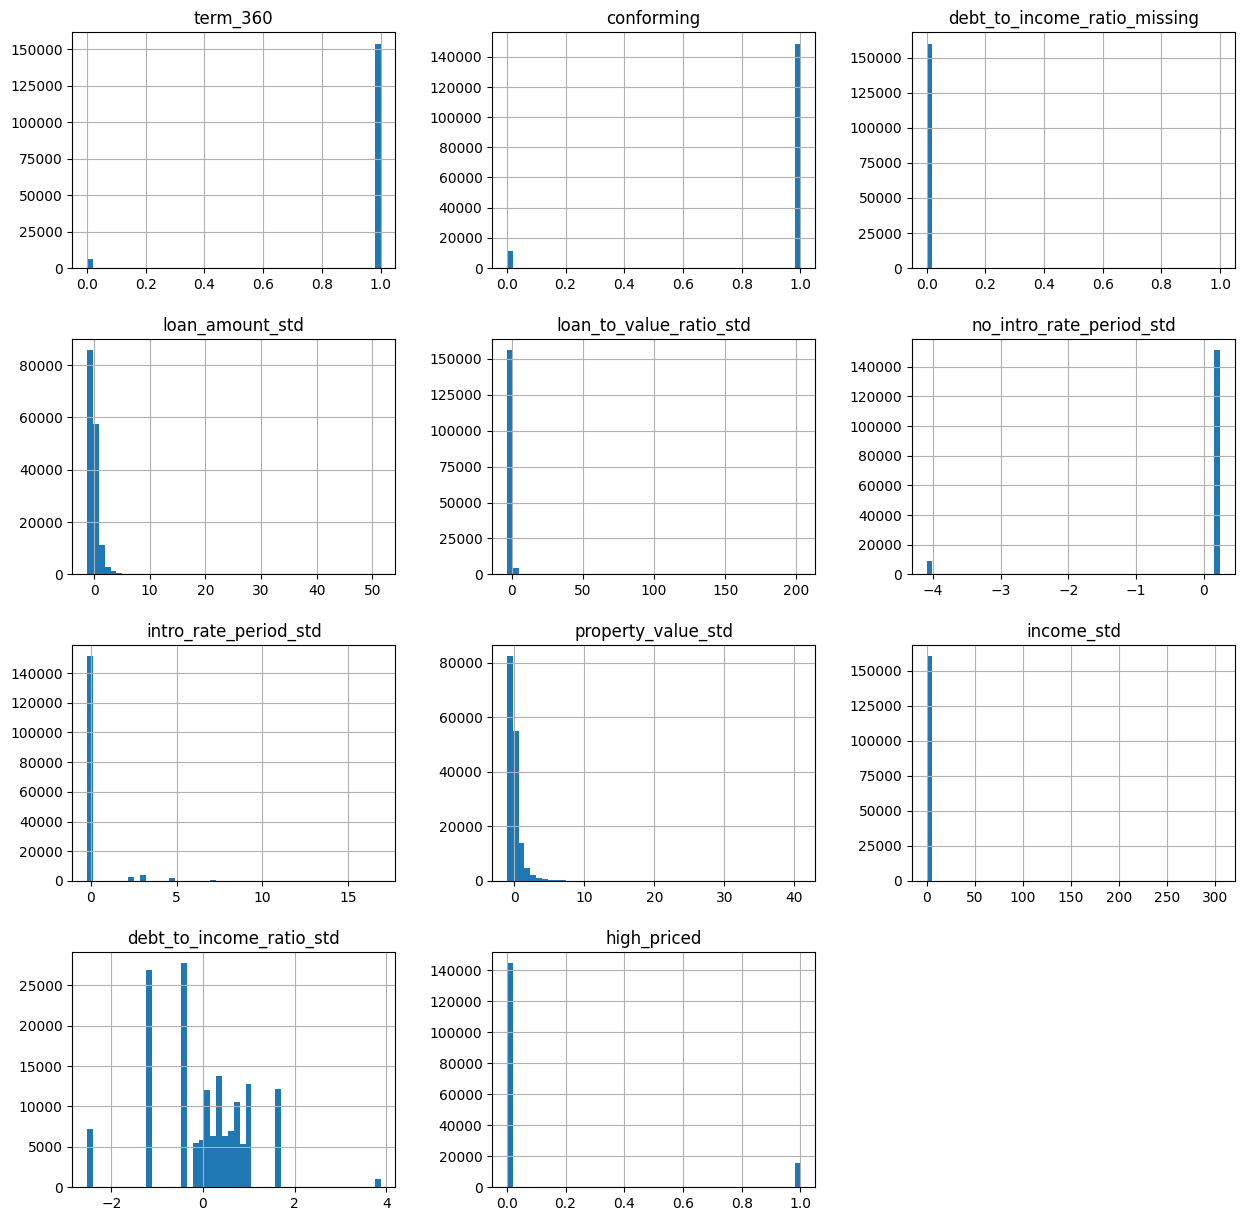

In [7]:
#Making histograms of the features to be analyzed and the target
_ = train_data[features + [target]].hist(bins=50, figsize=(15, 15))

#### Correlations

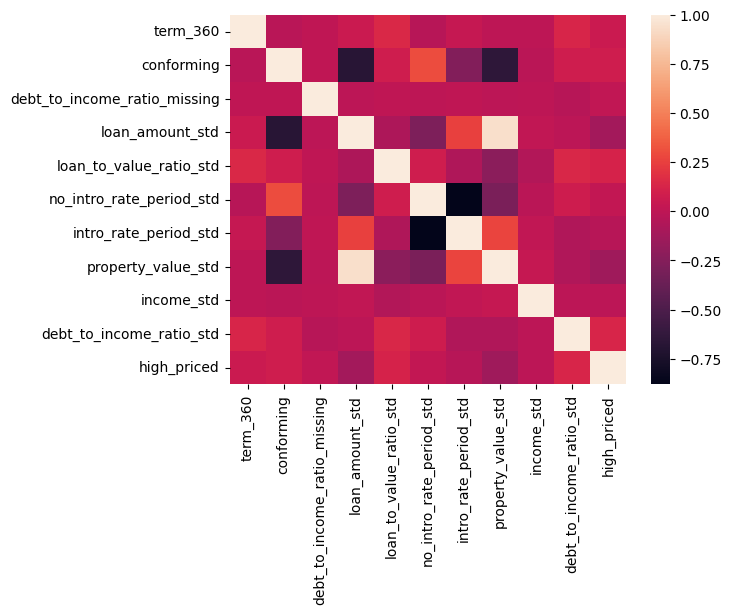

In [8]:
#Looking at the correlations between the features to be analyed and the target
corr = train_data[features + [target]].corr()
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

### **Fitting the Data**

In [9]:
#Preserve exact reproducibility for this cell
np.random.seed(SEED) 

#Choosing a 70/30 train/test split 
split_ratio = 0.7

#Execute split
split = np.random.rand(len(train_data)) < split_ratio
train = train_data[split]
valid = train_data[~split]

#Summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

#Benchmark - Train data rows = 112253, columns = 23
#Benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### **Setting up Model - Elastic Net**

#### Define wrapper function for grid search

In [10]:
def glm_grid(features, target, htrain, hvalid, seed):

    """ Wrapper function for penalized GLM with alpha and lambda search.

    :param features: Names of input features.
    :param target: Name of target feature.
    :param htrain: Training H2OFrame.
    :param hvalid: Validation H2OFrame.
    :param seed: Random seed for better reproducibility.
    :return: Best H2OGeneralizedLinearEstimator.
    """

    alpha_opts = [0.01, 0.25, 0.5, 0.99]  #Always keep some L2

    #Define search criteria
    #I.E., over alpha
    #Lamda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts}

    #Initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family='binomial',
                                      lambda_search=True,
                                      seed=seed), # seed for grid search
        hyper_params=hyper_parameters)

    #Execute training w/ grid search
    grid.train(y=target,
               x=features,
               training_frame=htrain,
               validation_frame=hvalid,
               seed=seed) # seed for training

    #Select best model from grid search
    best_model = grid.get_grid()[0]
    del grid

    return best_model

#### Fit elastic net with grid search

In [11]:
#Start local timer
glm_tic = time.time()

#Convert data to h2o frames
htrain = h2o.H2OFrame(train)
hvalid = h2o.H2OFrame(valid)

#Train with grid search
best_glm = glm_grid(features, target, htrain, hvalid, SEED)

#End local timer
glm_toc = time.time() - glm_tic
print('Elastic net GLM training completed in %.2f s.' % (glm_toc))

Elastic net GLM training completed in 13.45 s.


C:\Users\Zeyu\AppData\Roaming\Python\Python310\site-packages\h2o\grid\grid_search.py:434: UserWarning: Adding alpha array to hyperparameter runs slower with gridsearch. This is due to the fact that the algo has to run initialization for every alpha value. Setting the alpha array as a model parameter will skip the initialization and run faster overall.
  warnings.warn(w_message)


#### Basic AUC assessment

In [12]:
print('Validation AUC: %.4f.' % best_glm.auc(valid=True))

Validation AUC: 0.7538.


#### Score validation data with model

In [13]:
best_glm_phat = best_glm.predict(hvalid).as_data_frame()
best_glm_phat.drop(['predict', 'p0'], axis=1, inplace=True)
best_glm_phat.columns = ['phat']
best_glm_phat = pd.concat([valid.reset_index(drop=True), best_glm_phat], axis=1)
best_glm_phat.head()

C:\Users\Zeyu\AppData\Roaming\Python\Python310\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.158336
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.159289
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.070368
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.124670
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.045170


#### **Collection Local and Global Feature Information**

#### Utility Function for Selecting Percentiles

In [14]:
def get_percentile_dict(yhat_name, frame, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
        :param yhat_name: Name of column in frame in which to find percentiles.
        :param frame: Pandas frame.
        :param id_: Validation Pandas frame containing yhat and id_.
        :return: Dictionary of percentile values and index column values.
    """

    #Create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    #Find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    #Find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict

#### Select Percentiles from Predictions

In [15]:
best_glm_percentiles = get_percentile_dict('phat', best_glm_phat, 'row_id')
for key in sorted(best_glm_percentiles.keys()):
    print(str(key) + ': ' + str(best_glm_percentiles[key]))

0: 152878
10: 154185
20: 74908
30: 37440
40: 138502
50: 78582
60: 139677
70: 156880
80: 26748
90: 95570
99: 46601


#### Collect Global Feature Importance Info

In [16]:
#Use coefficients as relative global feature importance
global_fi = pd.DataFrame.from_dict(best_glm.coef(), columns=['GLM Importance'], orient='index')
global_fi.drop('Intercept', inplace=True)
global_fi['GLM Importance'] = np.abs(global_fi['GLM Importance'])

#### Collect Local Feature Importance Info

In [17]:
#Use (coefficient * value) as local feature importance

#Init frame to store local contribs
local_fi_dict = {10: pd.DataFrame(columns = ['GLM Contribution'], index=features),
                 50: pd.DataFrame(columns = ['GLM Contribution'], index=features),
                 90: pd.DataFrame(columns = ['GLM Contribution'], index=features)}

#Get (coefficient * value) at three percentiles of phat
for name in features:
    for percentile in [10, 50, 90]:

        # local contributions = beta_j * x_i,j
        local_fi_dict[percentile].loc[name, 'GLM Contribution'] =\
            best_glm.coef()[name] *\
            valid[valid['row_id'] == int(best_glm_percentiles[percentile])][name].values[0]

### **Setting up Model - Monotonic GBM**

***This function was updated using ChatGPT to ensure that it only runs on a single set of parameters and does not use the grid search.***

In [18]:
def mxgb_no_grid(dtrain, dvalid, mono_constraints=None, gs_params=None,
                 ntree=None, early_stopping_rounds=None, verbose=False, seed=None, cvfolds=5):
    
    """ Trains an XGBoost model using fixed parameters and tracks AUC.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Trained XGBoost model and the evaluation result dictionary.
    """
    
    #Set global params for objective, etc.
    params = {
        'booster': 'gbtree',
        'eval_metric': 'auc',  
        'nthread': NTHREAD,
        'objective': 'binary:logistic',
        'seed': SEED,
    }

    #Merge gs_params into params
    if gs_params is not None:
        params.update({k: v[0] if isinstance(v, list) else v for k, v in gs_params.items()})
        
    #If monotonic constraints are provided, update params
    if mono_constraints is not None:
        params['monotone_constraints'] = mono_constraints

    #Prepare the watchlist for training
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    print("Training with parameters:", params)

    #Store the evaluation results during training
    evals_result = {}

    #Train XGBoost model
    model = xgb.train(params,
                      dtrain,
                      ntree,
                      evals=watchlist,
                      evals_result=evals_result,  
                      verbose_eval=verbose)
    
    return model, evals_result

#### Fitting monotonic XGBoost with specific parameters and showing the AUC

Grid search was previously modified by running a larger `number of models` (n=150), adding in 3 new options for `max_depth` (9, 11, and 13), adding two new options for `eta` (0.001 and 0.1), adding 0.0001 and 0.1 to both `reg_alpha` and `reg_lambda`, and specifying 5 `cross-validation folds`. 

***This is now running specifically with the parameters defined by a previous grid search that resulted in the highest AUC.***

In [19]:
#Dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.9],
             'colsample_bylevel': [0.9],
             'eta': [0.1],
             'max_depth': [9],
             'reg_alpha': [0.05],
             'reg_lambda': [0.1],
             'subsample': [0.9],
             'min_child_weight': [1], 
             'gamma': [0.1]}

#Define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train_data[features + [target]].corr()[target].values[:-1])])

#Start local timer
mxgb_tic = time.time()

#Convert data to SVMLight format
dtrain = xgb.DMatrix(train_data[features], train_data[target])
dvalid = xgb.DMatrix(valid[features], valid[target])

#Monotonic XGBoost grid search
mxgbmodel, evals_result = mxgb_no_grid (dtrain, dvalid, gs_params=gs_params, ntree=1000,  early_stopping_rounds=100,  
                     mono_constraints=mono_constraints, seed=SEED)

#End local timer
mxgb_no_grid_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_no_grid_toc))

Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.1, 'max_depth': 9, 'reg_alpha': 0.05, 'reg_lambda': 0.1, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
Monotonic GBM training completed in 31.13 s.


#### Computing the Validation AUC for this Model

In [20]:
best_auc = max(evals_result['eval']['auc'])
print(f"Best Validation AUC: {best_auc:.4f}")

Best Validation AUC: 0.7945


#### Score Validation with Model

***This code was updated using ChatGPT to ensure that best_mxgb_phat is calculated based on the specific set of parameters chosen and to avoid errors we got with `best_iteration`.***

In [21]:
#Check if 'best_iteration' exists, else fallback to ntree
ntree = 1000
best_iteration = getattr(mxgbmodel, 'best_iteration', ntree)

#Make predictions using the best iteration
best_mxgb_phat = pd.DataFrame(mxgbmodel.predict(dvalid, iteration_range=(0, best_iteration)), columns=['phat'])

#Concatenate predictions with the validation data
best_mxgb_phat = pd.concat([valid.reset_index(drop=True), best_mxgb_phat], axis=1)

#Show the first few rows
best_mxgb_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.242346
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.244065
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.034223
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.020422
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.008534


#### **Collection Local and Global Feature Information**

#### Selecting Percentiles from Predictions

In [22]:
best_mxgb_percentiles = get_percentile_dict('phat', best_mxgb_phat, 'row_id')
for key in sorted(best_mxgb_percentiles.keys()):
    print(str(key) + ': ' + str(best_mxgb_percentiles[key]))

0: 105001
10: 118086
20: 66221
30: 132222
40: 29024
50: 99495
60: 135174
70: 130096
80: 42659
90: 56710
99: 134579


#### Calculating Shapley Values

***This code was updated using ChatGPT to ensure that Shapley contributions can be calculated based on the specific set of parameters chosen and to avoid errors we got with `best_iteration`.***

In [23]:
shapley_contribs = mxgbmodel.predict(dvalid, pred_contribs=True, iteration_range=(0, ntree))

#### Collecting Global Feature Importance Info

In [24]:
#Use mean abs SHAP as feature importance
shapley_contribs_df = pd.DataFrame(shapley_contribs, columns=features + ['intercept'])
global_fi['MXGB Importance'] = np.abs(shapley_contribs_df.drop('intercept', axis=1)).mean()

#### Collecting Local Feature Importance Info

In [25]:
#Create mapping between validation row_id and Shapely array index values
valid_idx_map = valid['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True)

#Collect SHAP values at three percentiles of phat
for percentile in [10, 50, 90]:

    #Using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_mxgb_percentiles[percentile])].index[0]
    s_df = pd.DataFrame(shapley_contribs[idx, :-1].T, columns=['MXGB Contribution'], index=features)
    local_fi_dict[percentile]['MXGB Contribution'] = 0
    local_fi_dict[percentile].update(s_df)

C:\Users\Zeyu\AppData\Local\Temp\ipykernel_1456\3363297073.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4.20734398e-02  1.66649790e-03 -8.41174100e-04 -1.93181008e-01
 -1.61113894e+00  6.45371503e-04  1.74026173e-02 -4.97190267e-01
 -3.87359783e-02 -2.55122989e-01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  local_fi_dict[percentile].update(s_df)
C:\Users\Zeyu\AppData\Local\Temp\ipykernel_1456\3363297073.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.01793321  0.00137417 -0.00077804 -0.34647036  0.39971882  0.00120918
  0.01243708 -0.48924583 -0.01479842 -0.11857856]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  local_fi_dict[percentile].update(s_df)
C:\Users\Zeyu\AppData\Local\Temp\ipykernel_1456\3363297073.py:13: FutureWarning: Settin

### **Setting up Model - EBM**

***This function was updated using ChatGPT to ensure that it only runs on a single set of parameters and does not use the grid search.***

In [26]:
def ebm_no_grid(train, valid, features, target, gs_params=None, early_stopping_rounds=None, seed=None, cv=5):
    
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param features: Names of input features.
    :param target: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    #Preserve exact reproducibility for this function
    np.random.seed(SEED) 

    #Extract parameters directly from gs_params (you can select the combination you want)
    params = gs_params
    
    #Set global parameters
    params.update({
        'n_jobs': NTHREAD,  
        'early_stopping_rounds': early_stopping_rounds,
        'random_state': seed
    })

    #Train the model
    ebm = ExplainableBoostingClassifier(**params)
    candidate = ebm.fit(train[features], train[target])
    
    #Calculating the AUC 
    ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[features], valid[target])
    candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
    #Return the trained model
    return candidate

#### Fitting the EBM with specific parameters and showing the AUC

Grid search was originally modified by running a larger `number of models` (n=150), adding 1,024, 2,048 and 3,072 as options for adding `max_bins`, adding 24 and 40 as an option for `max_interaction_bins`, adding 7 as an option for the `max_leaves`, and defining 5 `cross-validation folds` instead of the standard 3.

***This is now running specifically with the parameters defined by a previous grid search that resulted in the highest AUC.***

In [27]:
#Dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': 2048,
             'max_interaction_bins': 40,
             'interactions': 15,
             'outer_bags': 12, 
             'inner_bags': 4,
             'learning_rate': 0.01,
             'validation_size': 0.25,
             'min_samples_leaf': 10,
             'max_leaves': 3}

#Start local timer
ebm_tic = time.time()

#EBM grid search
best_ebm_no_grid = ebm_no_grid(train, valid, features, target, gs_params=gs_params, 
                    early_stopping_rounds=100, seed=SEED)

#End local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

EBM training completed in 107.95 s.


#### Computing the Validation AUC for this Model

In [28]:
#Showing the highest validation score found from the grid search conducted
best_ebm_perf = ROC(best_ebm_no_grid.predict_proba).explain_perf(valid[features], valid[target])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8255.


#### Score Validation with Model

In [29]:
best_ebm_phat = pd.DataFrame(best_ebm_no_grid.predict_proba(valid[features])[:, 1], columns=['phat'])
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.185431
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.312181
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.024768
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.016959
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.004471


#### **Collection Local and Global Feature Information**

#### Selecting Percentiles from Predictions

In [30]:
best_ebm_percentiles = get_percentile_dict('phat', best_ebm_phat, 'row_id')
for key in sorted(best_ebm_percentiles.keys()):
    print(str(key) + ': ' + str(best_ebm_percentiles[key]))

0: 27502
10: 121018
20: 62039
30: 51247
40: 102155
50: 27427
60: 11765
70: 145590
80: 59701
90: 28461
99: 117445


#### Calculating EBM Contributions

In [31]:
# start local timer
ebm_tic = time.time()

# use EBM feature scores as local importance
# use mean abs score as global importance
best_ebm_contribs = best_ebm_no_grid.explain_local(valid[features])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
# new versions just have predict_and_explain() function
# use that if you can
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, 25), columns=names)
    best_ebm_contribs_df = pd.concat([best_ebm_contribs_df, row_df], axis=0)
    del row_df

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))

C:\Users\Zeyu\AppData\Local\Temp\ipykernel_1456\740659309.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  best_ebm_contribs_df = pd.concat([best_ebm_contribs_df, row_df], axis=0)


EBM contributions collected in 89.21 s.


#### Collecting Global Feature Importance Info

In [32]:
global_fi['EBM Importance'] = np.abs(best_ebm_contribs_df).mean()

#### Collecting Local Feature Importance Info

In [33]:
# extract scores at three percentiles of phat
for percentile in [10, 50, 90]:

    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_ebm_percentiles[percentile])].index[0]
    s_df = best_ebm_contribs_df.iloc[idx, :len(features)].T
    s_df.columns = ['EBM Contribution']
    local_fi_dict[percentile]['EBM Contribution'] = s_df

#### Variable Importance

In [34]:
ebm = ExplainableBoostingClassifier(random_state=SEED, n_jobs=-1)
ebm.fit(train[features], train[target])

ExplainableBoostingClassifier(random_state=12345)

<Axes: ylabel='feature_names'>

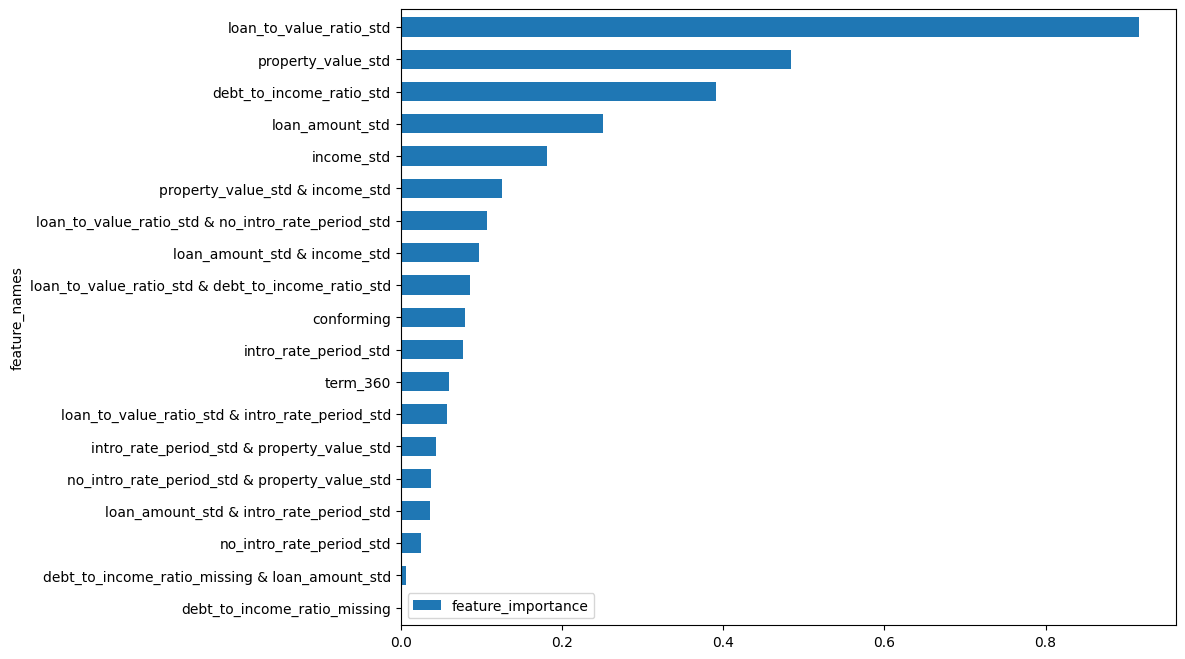

In [35]:
ebm_global = ebm.explain_global(name='EBM')
feature_names = ebm_global._internal_obj['overall']['names']
feature_importances = ebm_global._internal_obj['overall']['scores']

ebm_variable_importance = pd.DataFrame(zip(feature_names, feature_importances),
                                       columns=['feature_names','feature_importance'])

ebm_variable_importance.set_index('feature_names',inplace=True)
ebm_variable_importance.sort_values(by='feature_importance').plot(kind='barh',
                                                                       width = 0.6,
                                                                       figsize=(10,8))

### **Analyzing Feature Importance**

#### Comparing Global Feature Importance Across Models

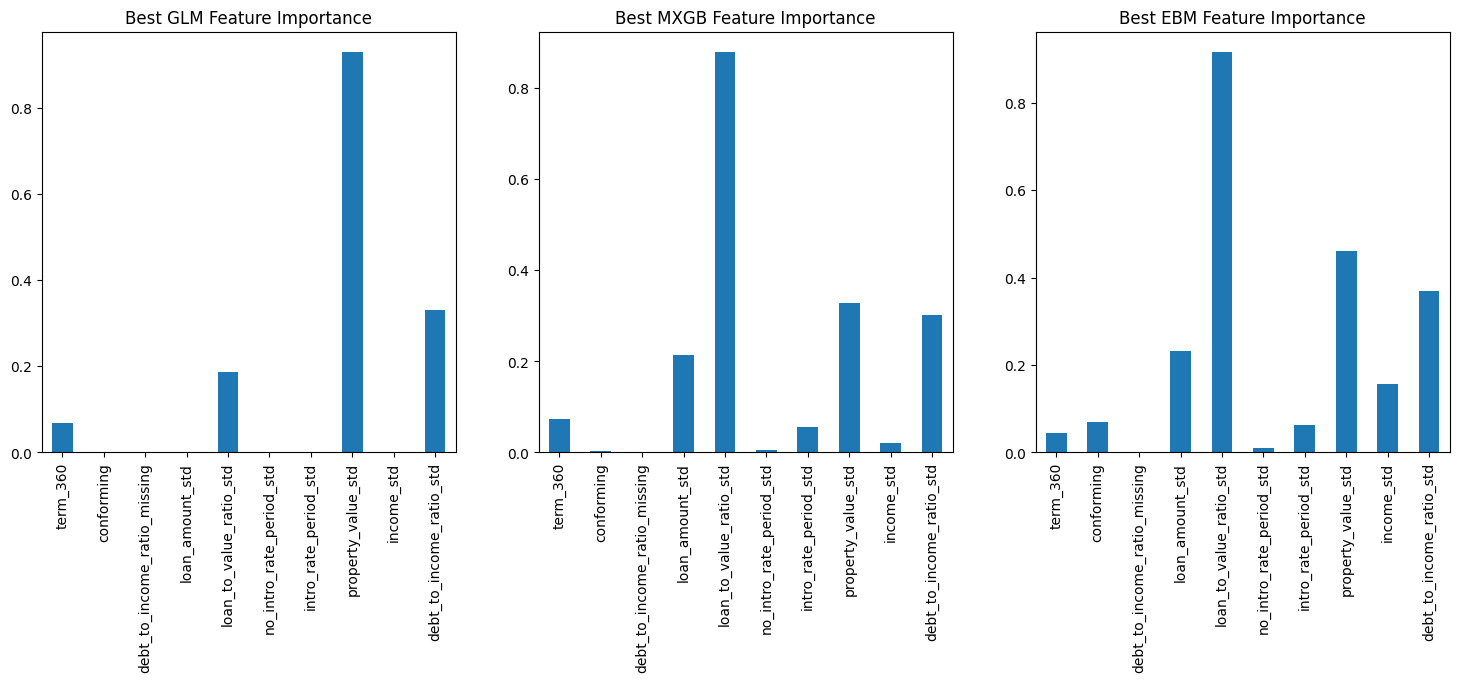

In [36]:
#Init 3-pane plot
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

#Plot global FI across three panes
_ = global_fi['GLM Importance'].plot(kind='bar', ax=ax0, title='Best GLM Feature Importance')
_ = global_fi['MXGB Importance'].plot(kind='bar', ax=ax1, title='Best MXGB Feature Importance')
_ = global_fi['EBM Importance'].plot(kind='bar', ax=ax2, title='Best EBM Feature Importance')

#### Comparing Local Feature Importance Across Models

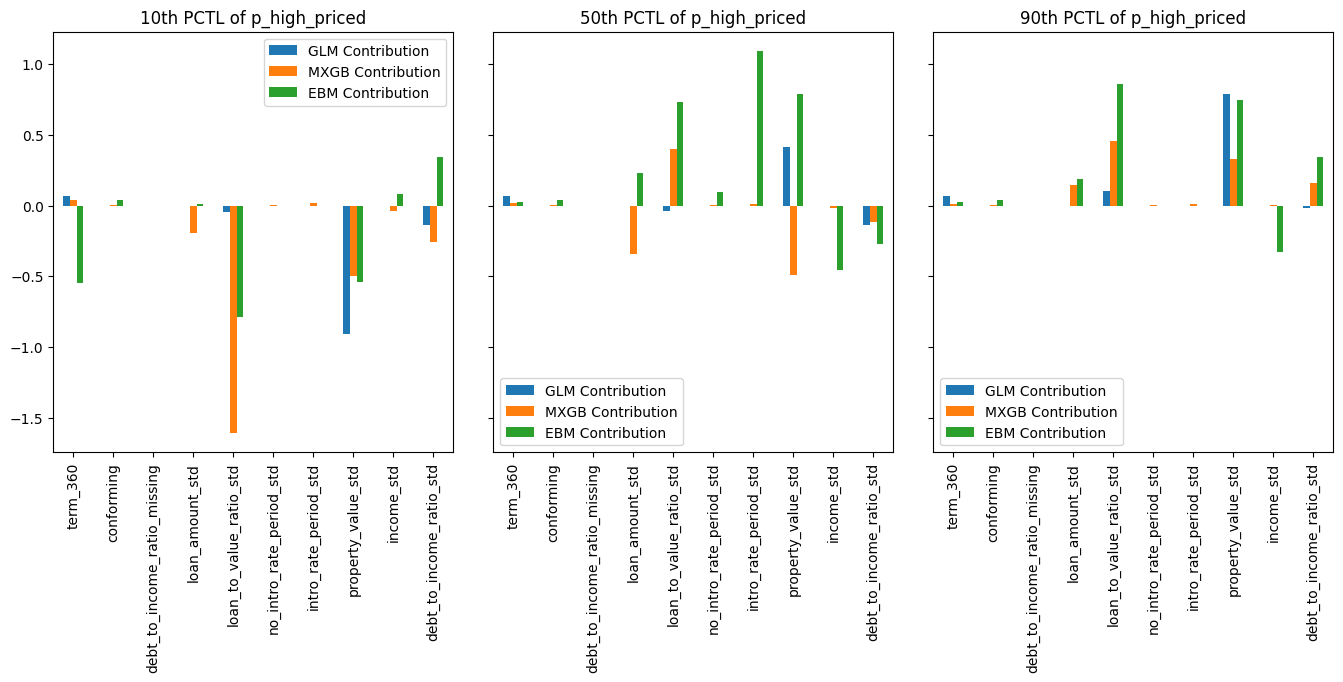

In [37]:
##Init 3-pane plot
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

#Plot comparisons of local FI across 3 panes
_ = local_fi_dict[10].plot(kind='bar', ax=ax0,
                             title='10th PCTL of p_high_priced')

_ = local_fi_dict[50].plot(kind='bar', ax=ax1,
                             title='50th PCTL of p_high_priced')

_ = local_fi_dict[90].plot(kind='bar', ax=ax2,
                             title='90th PCTL of p_high_priced')

#### Utility Function for Partial Dependence

***This code was updated using ChatGPT to ensure that par_dep can run correctly on the specific set of parameters chosen for the MXGB and EBM models and to avoid errors we got with `best_iteration`.***

In [38]:
def par_dep(features, valid, model, model_type, resolution=20, bins=None):
    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param features: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # Turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # Determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[features].min()
        max_ = valid[features].max()
        by = (max_ - min_) / resolution
        # Modify max and by to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))

    # Cache original column values
    col_cache = valid.loc[:, features].copy(deep=True)

    # Calculate partial dependence by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, features] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, features] = bins[j + 1]
            temp_df = pd.concat([temp_df, valid], axis=0)

    temp_df.reset_index(inplace=True, drop=True)  # Or else dumb pandas indexes cause all rows to have same partial dependence

    # Return input frame to original cached state
    valid.loc[:, features] = col_cache

    # Model predictions
    if model_type == 'h2o':
        temp_df['partial_dependence'] = model.predict(h2o.H2OFrame(temp_df))['p1'].as_data_frame()
    if model_type == 'xgb':
        # Check if early stopping was used and model has best_iteration attribute
        try:
            # If early stopping was used, use best_iteration
            iteration_range = (0, model.best_iteration)
        except AttributeError:
            # If no early stopping was used, use the full number of boosting rounds
            if hasattr(model, 'best_iteration'):
                iteration_range = (0, model.best_iteration)
            elif hasattr(model, 'attributes') and 'num_boosting_rounds' in model.attributes():
                iteration_range = (0, model.attributes()['num_boosting_rounds'])
            else:
                # Fallback to 0 and a large number of boosting rounds (adjust accordingly)
                iteration_range = (0, 1000)  # Assuming 1000 as a large enough number of boosting rounds

        # Get predictions for XGBoost model
        temp_df['partial_dependence'] = pd.DataFrame(
            model.predict(xgb.DMatrix(temp_df), iteration_range=iteration_range), columns=['phat']
        )
    if model_type == 'ebm':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict_proba(temp_df)[:, 1], columns=['phat'])

    return pd.DataFrame(temp_df[[features, 'partial_dependence']].groupby([features]).mean()).reset_index()

#### Calcuting Partial Dependence for all X and Models

In [39]:
#Start local timer
pd_tic = time.time()

#Init dict to hold results
pd_dict = {}

#Cycle through names and model types to calculate par dep
for name in features:

    print('Calculating partial dependence for %s ...' % name)

    # setup a dataframe to hold results
    # use bins from first par_dep() run
    pd_dict[name] = pd.DataFrame(columns=[name, 'h2o', 'xgb', 'ebm'])
    first_pd = par_dep(name, valid[features], best_glm, 'h2o')
    pd_dict[name][name] = first_pd[name]
    bins = first_pd[name]
    pd_dict[name]['h2o'] = first_pd['partial_dependence']

    # calculate par dep for remaining models
    pd_dict[name]['xgb'] = par_dep(name, valid[features], mxgbmodel, 'xgb', bins=bins)['partial_dependence']
    pd_dict[name]['ebm'] = par_dep(name, valid[features], best_ebm_no_grid, 'ebm', bins=bins)['partial_dependence']

print('Done.')

#End local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % (pd_toc))

Calculating partial dependence for term_360 ...


C:\Users\Zeyu\AppData\Local\Temp\ipykernel_1456\3917697474.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid.loc[:, features] = bins[j + 1]
C:\Users\Zeyu\AppData\Roaming\Python\Python310\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\Zeyu\AppData\Local\Temp\ipykernel_1456\3917697474.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explic

Calculating partial dependence for conforming ...


C:\Users\Zeyu\AppData\Local\Temp\ipykernel_1456\3917697474.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid.loc[:, features] = bins[j + 1]
C:\Users\Zeyu\AppData\Roaming\Python\Python310\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\Zeyu\AppData\Local\Temp\ipykernel_1456\3917697474.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explic

Calculating partial dependence for debt_to_income_ratio_missing ...


C:\Users\Zeyu\AppData\Local\Temp\ipykernel_1456\3917697474.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid.loc[:, features] = bins[j + 1]
C:\Users\Zeyu\AppData\Roaming\Python\Python310\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\Zeyu\AppData\Local\Temp\ipykernel_1456\3917697474.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.053000000000000005' has dtype incompatible with int64, please explic

Calculating partial dependence for loan_amount_std ...


C:\Users\Zeyu\AppData\Roaming\Python\Python310\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for loan_to_value_ratio_std ...


C:\Users\Zeyu\AppData\Roaming\Python\Python310\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for no_intro_rate_period_std ...


C:\Users\Zeyu\AppData\Roaming\Python\Python310\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for intro_rate_period_std ...


C:\Users\Zeyu\AppData\Roaming\Python\Python310\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for property_value_std ...


C:\Users\Zeyu\AppData\Roaming\Python\Python310\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for income_std ...


C:\Users\Zeyu\AppData\Roaming\Python\Python310\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Calculating partial dependence for debt_to_income_ratio_std ...


C:\Users\Zeyu\AppData\Roaming\Python\Python310\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Done.
Partial dependence calculated in 173.03 s.


#### Plotting Partial Dependence for all Features and Models

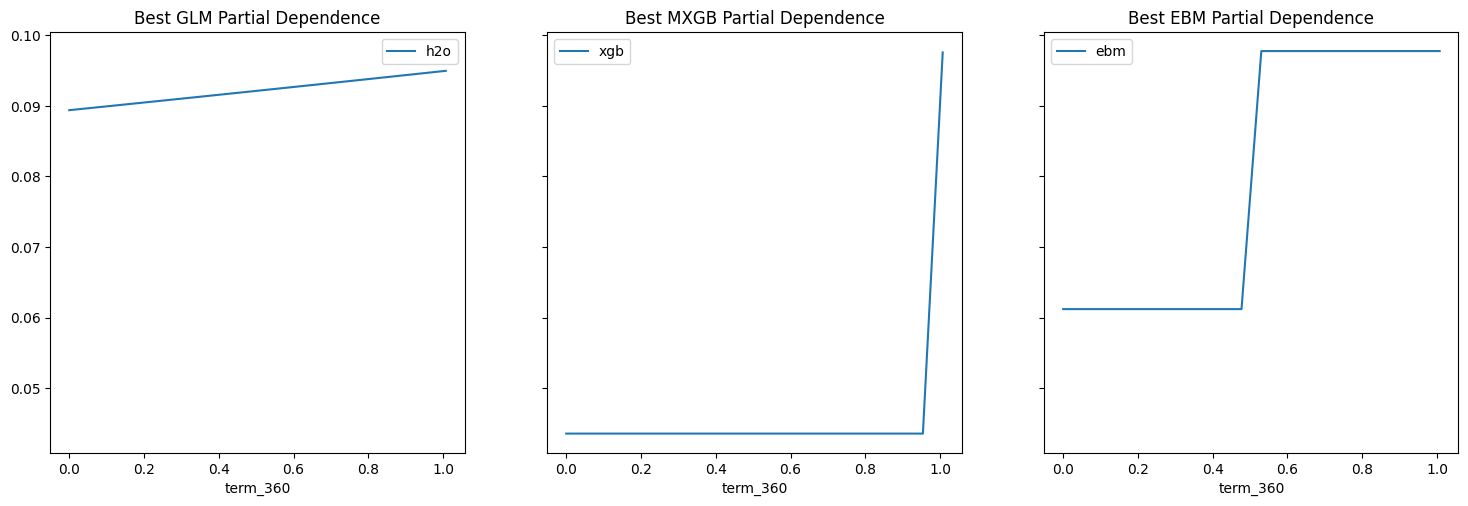

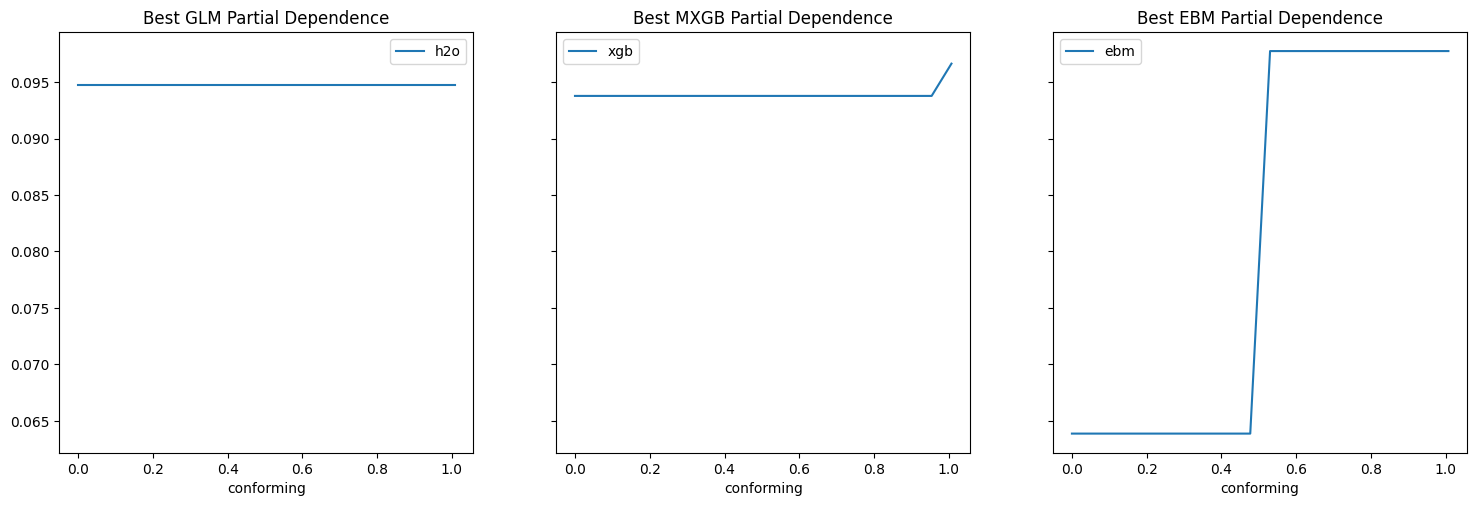

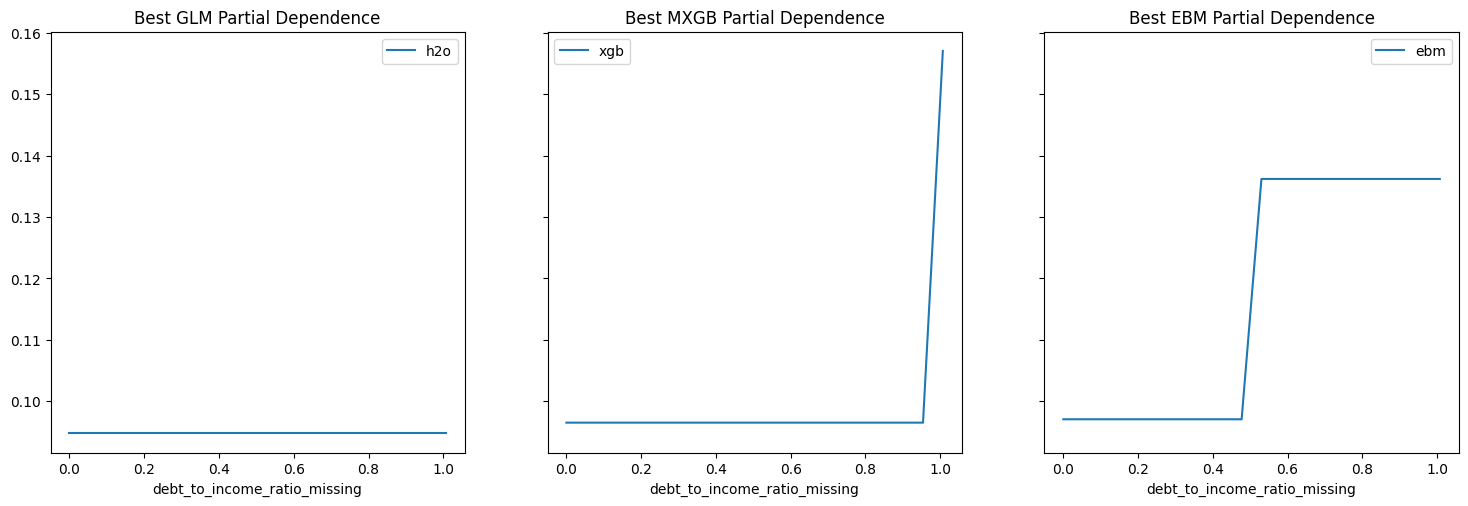

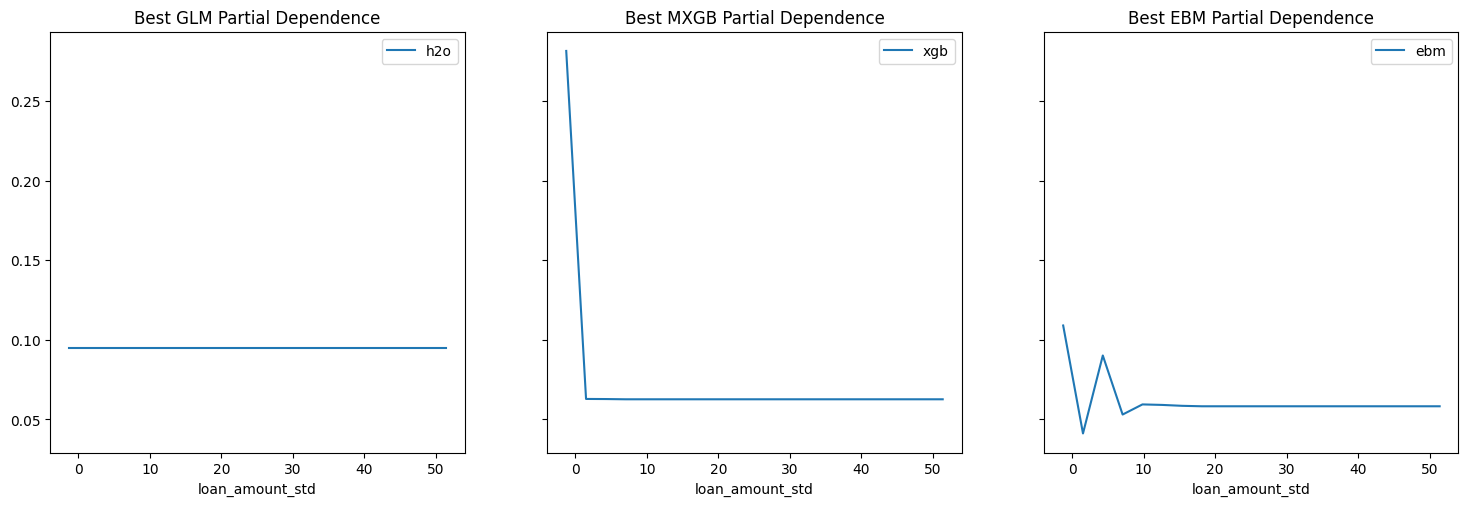

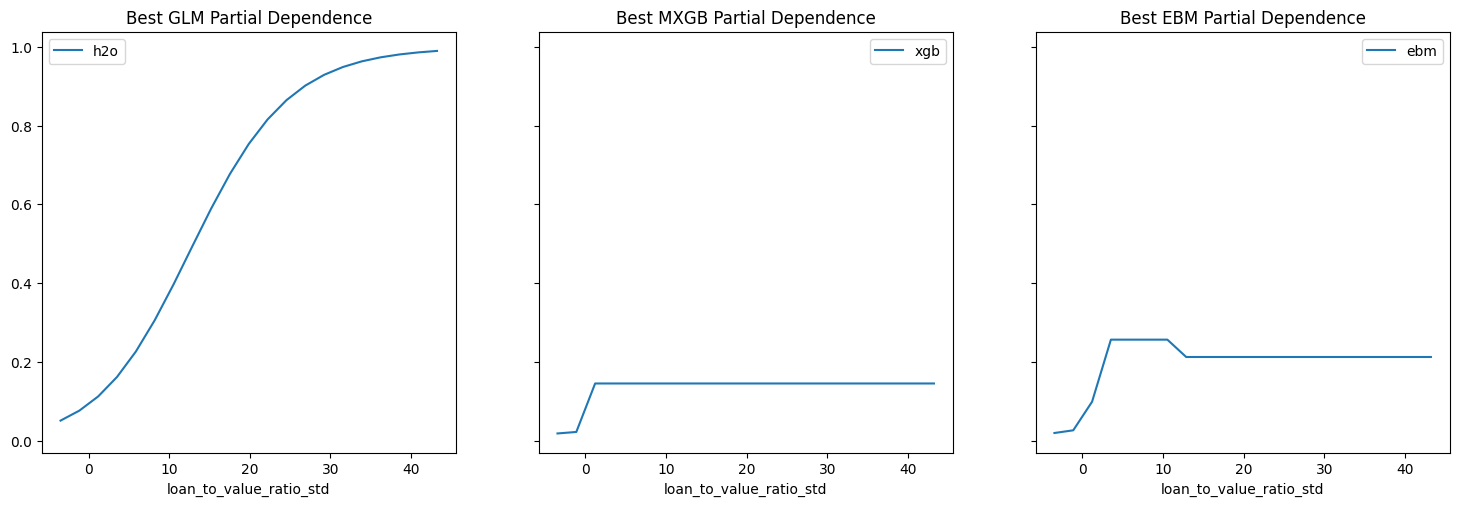

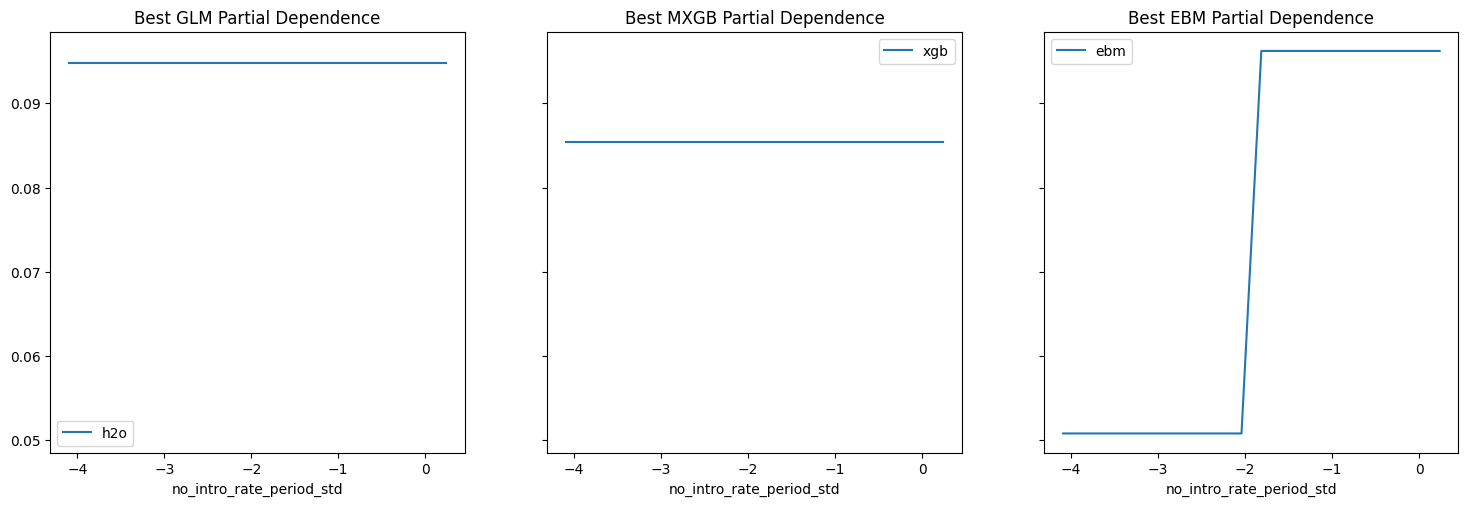

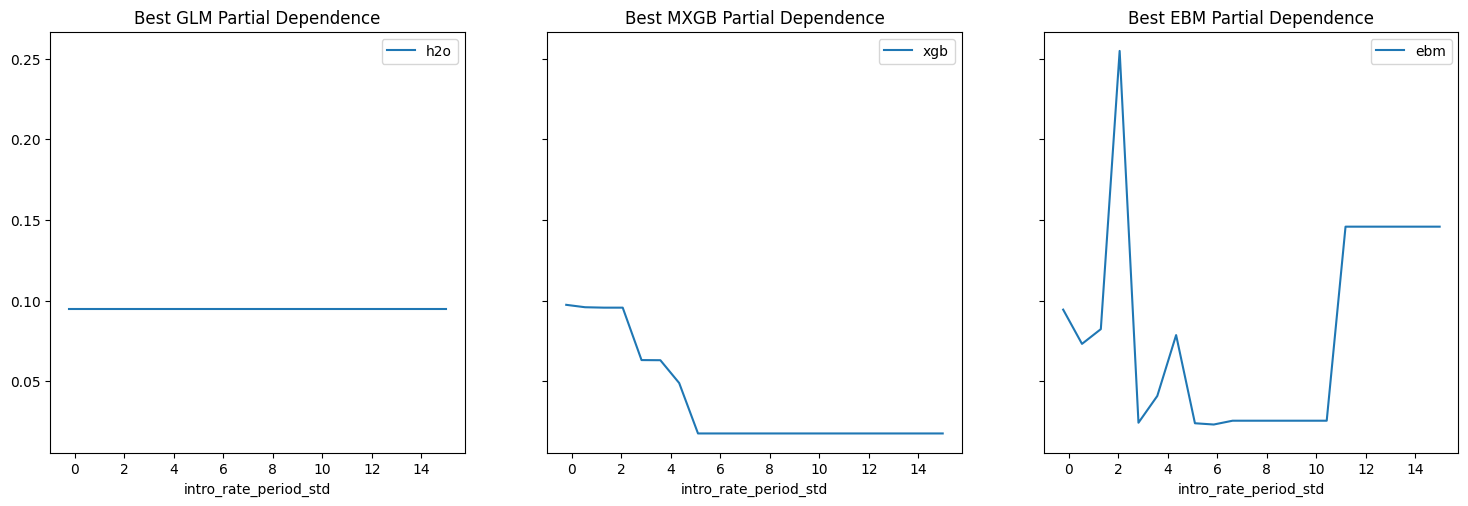

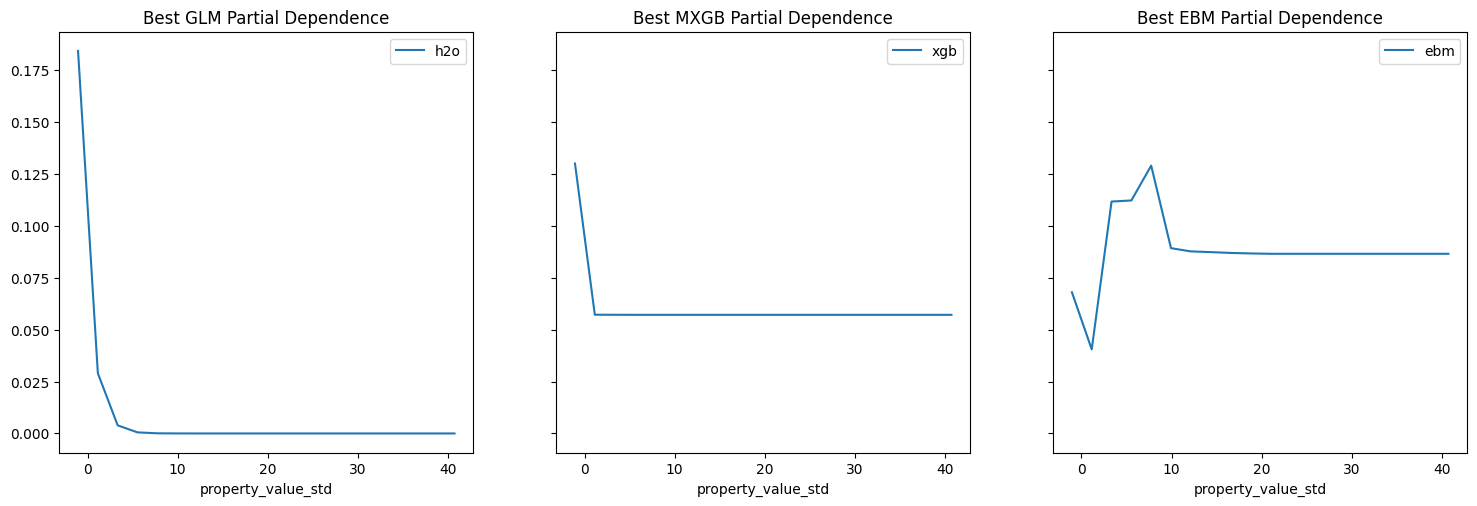

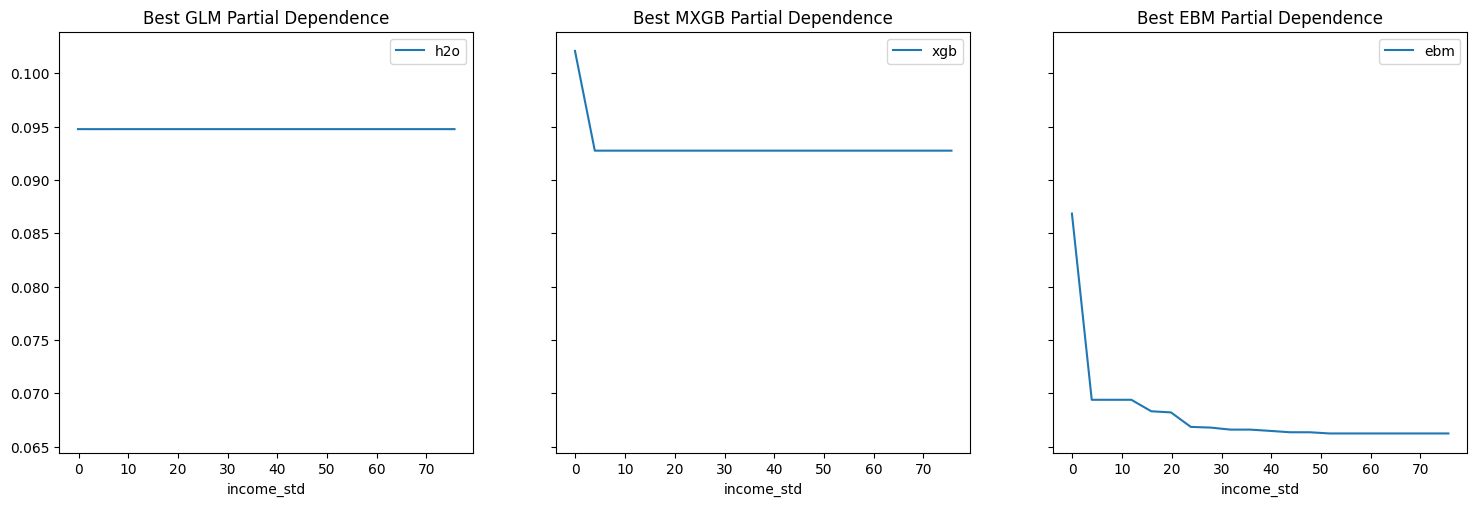

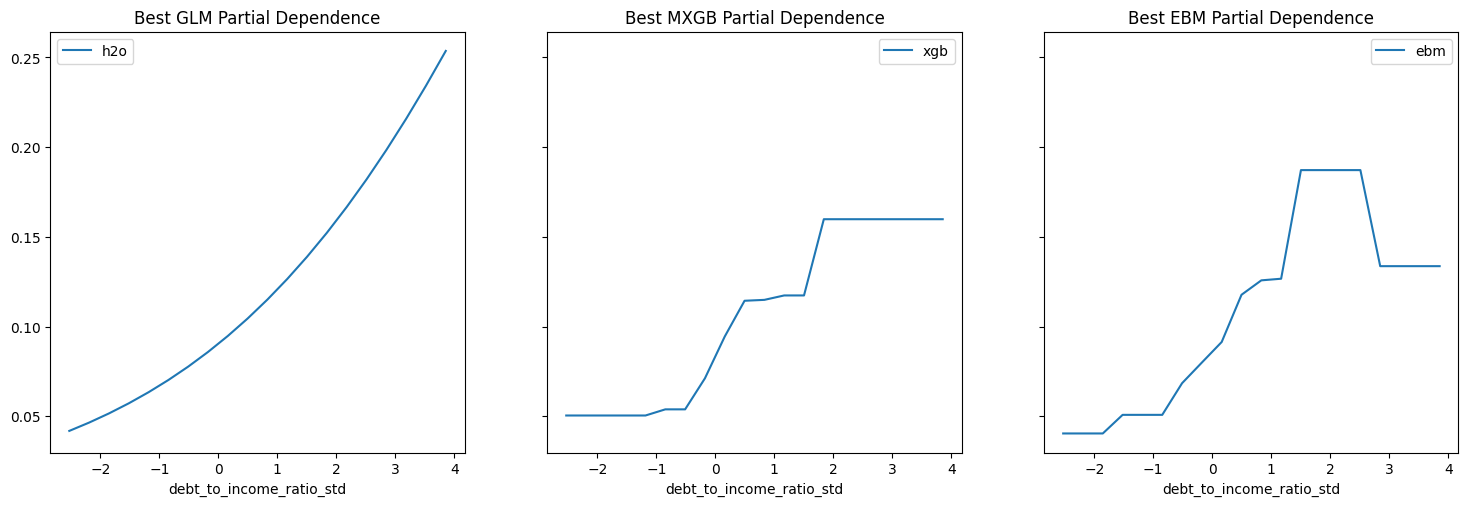

In [40]:
#loop through names to calculate par dep
for name in features:

    # init 3-pane plot
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='h2o', ax=ax0, title='Best GLM Partial Dependence')
    ax0.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='xgb', ax=ax1, title='Best MXGB Partial Dependence')
    ax1.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='ebm', ax=ax2, title='Best EBM Partial Dependence')
    ax2.set_xlabel(name)

#### End Timer

In [41]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 484.99 s.


#### Shutdown h2o

In [42]:
h2o.cluster().shutdown(prompt=False)

H2O session _sid_91e9 closed.


### **Defining Utility Functions**

#### Additional Necessary Imports

In [43]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import ROC
from sklearn.metrics import accuracy_score, f1_score  
import random

In [44]:
from sklearn.metrics import accuracy_score, f1_score, log_loss, mean_squared_error, roc_auc_score

#### Utility Function to Calculate Confusion Matrices by Demographic Group

In [45]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced
        by a variable and level.

        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Name of actual value column.
        :param yhat: Name of predicted value column.
        :param by: By variable to slice frame before creating confusion matrix, default None.
        :param level: Value of by variable to slice frame before creating confusion matrix, default None.
        :param cutoff: Cutoff threshold for confusion matrix, default 0.5.
        :param verbose: Whether to print confusion matrix titles, default True.
        :return: Confusion matrix as pandas dataframe.

    """

    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list],
                            index=['predicted: ' + str(i) for i in level_list])

    # don't destroy original data
    frame_ = frame.copy(deep=True)

    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)

    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]

    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19

    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))

    return cm_frame

#### Utility Function to Calculate AIR

In [46]:
def air(cm_dict, reference_key, protected_key, verbose=True):

    """ Calculates the adverse impact ratio as a quotient between protected and
        reference group acceptance rates: protected_prop/reference_prop.
        Optionally prints intermediate values. ASSUMES 0 IS "POSITIVE" OUTCOME!

        :param cm_dict: Dictionary of demographic group confusion matrices.
        :param reference_key: Name of reference group in cm_dict as a string.
        :param protected_key: Name of protected group in cm_dict as a string.
        :param verbose: Whether to print intermediate acceptance rates, default True.
        :return: AIR.

    """

    eps = 1e-20 # numeric stability and divide by 0 protection

    # reference group summary
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)

    # protected group summary
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    if np.isclose(protected_accepted, 0.0):
        return np.nan
    else:
        return ((protected_prop + eps)/(reference_prop + eps))

#### Utility Function to Select Probability Cutoff by F1

In [47]:
def get_max_f1_frame(frame, y, yhat, res=0.01, air_reference=None, air_protected=None, verbose=False):

    """ Utility function for finding max. F1.
        Coupled to get_confusion_matrix() and air().
        Assumes 1 is the marker for class membership.

        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Known y values.
        :param yhat: Model scores.
        :param res: Resolution over which to search for max. F1, default 0.01.
        :param air_reference: Reference group for AIR calculation, optional.
        :param air_protected: Protected group for AIR calculation, optional.
        :return: Pandas DataFrame of cutoffs to select from.

    """

    do_air = all(v is not None for v in [air_reference, air_protected])

    # init frame to store f1 at different cutoffs
    if do_air:
        columns = ['cut', 'f1', 'acc', 'air']
    else:
        columns = ['cut', 'f1', 'acc']
    f1_frame = pd.DataFrame(columns=['cut', 'f1', 'acc'])

    # copy known y and score values into a temporary frame
    temp_df = frame[[y, yhat]].copy(deep=True)

    # find f1 at different cutoffs and store in acc_frame
    for i, cut in enumerate(np.arange(0, 1 + res, res)):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        row_dict = {'cut': cut, 'f1': f1, 'acc': acc}
        if do_air:
            # conditionally calculate AIR
            cm_ref = get_confusion_matrix(frame, y, yhat, by=air_reference, level=1, cutoff=cut, verbose=verbose)
            cm_pro = get_confusion_matrix(frame, y, yhat, by=air_protected, level=1, cutoff=cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_

        f1_frame = pd.concat([f1_frame, pd.DataFrame(row_dict, index=[i])], axis=0)

    del temp_df

    return f1_frame

#### Utility Function for Random Grid Search

In [57]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None,
             air_reference=None, air_protected=None, air_cut=None, verbose=False):

    """ Performs a random grid search over n_models and gs_params.
        Optionally considers random feature sets and AIR.
        Coupled to get_confusion_matrix() and air().

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :param air_reference: Reference group for AIR calculation, optional.
    :param air_protected: Protected group for AIR calculation, optional.
    :param air_cut: Cutoff for AIR calculation, optional.
    :param verbose: Whether to print intermediate acceptance rates, default False.
    :return: Tuple: (Best EBM model, Pandas DataFrame of models to select from)

    """

    # init returned frame
    do_air = all(v is not None for v in [air_reference, air_protected])
    if do_air:
        columns = list(gs_params.keys()) + ['features', 'auc', 'air']
    else:
        columns = list(gs_params.keys()) + ['auc']
    ebm_grid_frame = pd.DataFrame(columns=columns)

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds,
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train
        ebm = ExplainableBoostingClassifier(**params)

        # conditionally select random features
        features = x_names
        if do_air:
            n_features = random.randrange(len(x_names)) + 1
            features = random.sample(x_names, n_features)
        candidate = ebm.fit(train[features], train[y_name])

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[features], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']

        # compose values to add to ebm_grid_frame
        row_dict = params.copy()
        row_dict['auc'] = candidate_best_score
        if do_air:
            # collect random feature set
            row_dict['features'] = features
            # conditionally calculate AIR
            valid_phat = valid.copy(deep=True)
            valid_phat['phat'] = candidate.predict_proba(valid[features])[:, 1]
            cm_ref = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_reference, level=1, cutoff=air_cut, verbose=verbose)
            cm_pro = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_protected, level=1, cutoff=air_cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_
            row_dict['features'] = ', '.join(row_dict['features'])
            del valid_phat

        # append run to ebm_grid_frame
        ebm_grid_frame = pd.concat([ebm_grid_frame, pd.DataFrame(row_dict, index=[i])], axis=0)

        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_score = candidate_best_score
            best_ebm = candidate
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')

        del row_dict
        del ebm

    return best_ebm, ebm_grid_frame

### **Investigate Best Model (EBM) for Discrimination**

#### Find optimal cutoff based on F1

Cutoffs are normally selected by maximizing a quality statistic or a business metric, and not by considering bias and discrimination.

In [49]:
f1_frame = get_max_f1_frame(best_ebm_phat, target, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut'] #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best EBM F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

C:\Users\Zeyu\AppData\Local\Temp\ipykernel_1456\2179274243.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  f1_frame = pd.concat([f1_frame, pd.DataFrame(row_dict, index=[i])], axis=0)


      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.231104  0.374649
2    0.02  0.261170  0.474514
3    0.03  0.278802  0.525736
4    0.04  0.295308  0.567058
..    ...       ...       ...
96   0.96  0.000000  0.904794
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best EBM F1: 0.3662 achieved at cutoff: 0.20 with accuracy: 0.8157.


#### Find confusion matrices for demographic groups

In [50]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_ebm_phat, target, 'phat', by=name, level=1, cutoff=best_cut)
    print(cm_dict[name])
    print()

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       409       757
predicted: 0       255      1771

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1        90       147
predicted: 0        58      2955

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      1742      5085
predicted: 0      1423     26275

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1       921      2602
predicted: 0       743     11566

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       749      1777
predicted: 0       491      7015



#### Find AIR for Asian people

In [51]:
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(cm_dict, 'white', 'asian'))

White proportion accepted: 0.802
Asian proportion accepted: 0.927
Adverse impact ratio for Asian people vs. White people: 1.156


#### Find AIR for Black people

In [52]:
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(cm_dict, 'white', 'black'))

White proportion accepted: 0.802
Black proportion accepted: 0.635
Adverse impact ratio for Black people vs. White people: 0.791


#### Find AIR for Females

In [53]:
print('Adverse impact ratio for Females vs. Males: %.3f' % air(cm_dict, 'male', 'female'))

Male proportion accepted: 0.777
Female proportion accepted: 0.748
Adverse impact ratio for Females vs. Males: 0.962


#### Attempt Remediation of Discovered Discrimination

Simplest remediation: Find cutoff with better Black vs. White AIR

In [54]:
f1_frame = get_max_f1_frame(best_ebm_phat, target, 'phat', air_reference='white', air_protected='black')
# print highest quality cutoffs above four fifths rule cutoff
f1_frame[f1_frame['air'] > 0.8].sort_values(by='f1', ascending=False).head()

C:\Users\Zeyu\AppData\Local\Temp\ipykernel_1456\2179274243.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  f1_frame = pd.concat([f1_frame, pd.DataFrame(row_dict, index=[i])], axis=0)


,cut,f1,acc,air
21,0.21,0.363581,0.825268,0.807594
22,0.22,0.362743,0.835520,0.825290
23,0.23,0.351407,0.843777,0.847998
24,0.24,0.342724,0.852989,0.870547
25,0.25,0.329073,0.860247,0.878769


#### Check That Other Groups Are Not Adversely Impacted by Change

In [55]:
# calculate new confusion matrics for each group
rem_cm_dict = {}
for name in demographic_group_names:
    rem_cm_dict[name] = get_confusion_matrix(best_ebm_phat, target, 'phat', by=name, level=1, cutoff=0.22, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.124
Adverse impact ratio for Black people vs. White people: 0.825
Adverse impact ratio for Females vs. Males: 0.967


The new cutoff does not adversely affect other protected groups.

#### More Sophisticated Remdiation: Model Selection Via Quality and Fairness

In [64]:
# Start local timer
ebm2_tic = time.time()

# Ensure all gs_params values are lists (required for itertools.product)
gs_params = {k: v if isinstance(v, (list, tuple)) else [v] for k, v in gs_params.items()}

# Make x_names global so ebm_grid can use it
x_names = features

# New grid search that also considers AIR and fairness
best_ebm2, ebm_grid_frame = ebm_grid(train, best_ebm_phat, features, target, gs_params=gs_params, n_models=25,
                                     early_stopping_rounds=100, seed=SEED, air_reference='white', air_protected='black',
                                     air_cut=0.17)

# End local timer
ebm2_toc = time.time() - ebm2_tic
print('EBM training completed in %.2f s.' % (ebm2_toc))

Grid search run 1/25:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 2048, 'max_interaction_bins': 40, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 3}


C:\Users\Zeyu\AppData\Local\Temp\ipykernel_1456\3173739067.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ebm_grid_frame = pd.concat([ebm_grid_frame, pd.DataFrame(row_dict, index=[i])], axis=0)


Grid search new best score discovered at iteration 1/25: 0.5189.
---------- ----------
Grid search run 2/25:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 2048, 'max_interaction_bins': 40, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 3}
Grid search new best score discovered at iteration 2/25: 0.8247.
---------- ----------
Grid search run 3/25:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 2048, 'max_interaction_bins': 40, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 3}
---------- ----------
Grid search run 4/25:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 2048, 'max_interaction_bins': 40, 'interactions': 15, 'outer_bags':

#### Display Grid Search Results as Table

In [65]:
ebm_grid_frame

,max_bins,max_interaction_bins,interactions,outer_bags,inner_bags,learning_rate,validation_size,min_samples_leaf,max_leaves,n_jobs,early_stopping_rounds,random_state,features,auc,air
0,2048,40,15,12,4,0.01,0.25,10,3,4,100,12345,term_360,0.518910,1.000000
1,2048,40,15,12,4,0.01,0.25,10,3,4,100,12345,"conforming, debt_to_income_ratio_missing, inco...",0.824654,0.723366
2,2048,40,15,12,4,0.01,0.25,10,3,4,100,12345,conforming,0.532687,1.000000
3,2048,40,15,12,4,0.01,0.25,10,3,4,100,12345,"term_360, income_std, property_value_std, intr...",0.804828,0.674896
4,2048,40,15,12,4,0.01,0.25,10,3,4,100,12345,"debt_to_income_ratio_missing, income_std, term...",0.655419,0.999151
5,2048,40,15,12,4,0.01,0.25,10,3,4,100,12345,"term_360, conforming, loan_amount_std, debt_to...",0.804548,0.697703
6,2048,40,15,12,4,0.01,0.25,10,3,4,100,12345,"loan_amount_std, debt_to_income_ratio_missing",0.660709,0.995112
7,2048,40,15,12,4,0.01,0.25,10,3,4,100,12345,"loan_to_value_ratio_std, property_value_std, t...",0.784537,0.646753
8,2048,40,15,12,4,0.01,0.25,10,3,4,100,12345,"income_std, conforming",0.648239,1.000011
9,2048,40,15,12,4,0.01,0.25,10,3,4,100,12345,"loan_to_value_ratio_std, intro_rate_period_std...",0.825904,0.721101


#### Display Grid Search Results as Plot

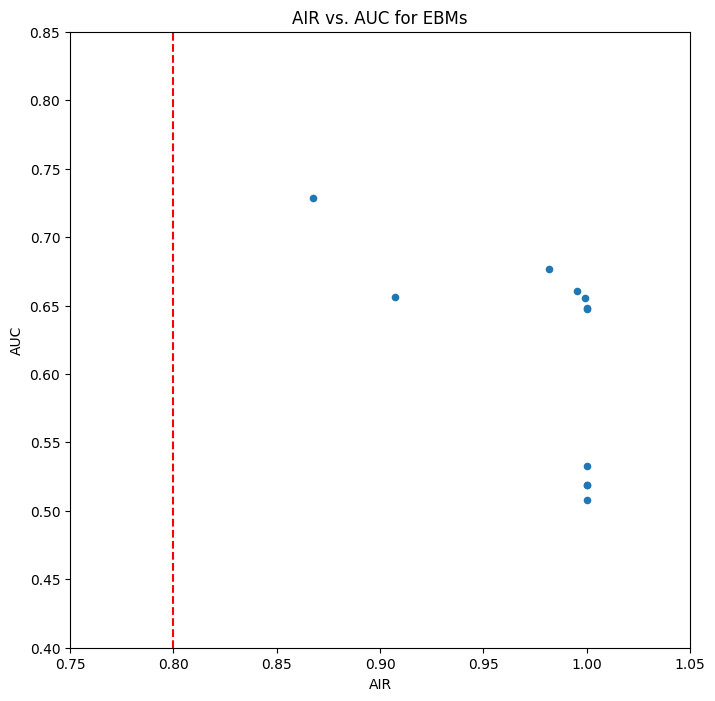

In [66]:
fig, ax = plt.subplots(figsize=(8,8))
_ = ebm_grid_frame.plot(kind='scatter', x='air', y='auc', title='AIR vs. AUC for EBMs', ax=ax)
_ = ax.axvline(x=0.8, color='r', linestyle='--')
_ = ax.set_ylim([0.4, 0.85])
_ = ax.set_xlim([0.75, 1.05])
_ = ax.set_xlabel('AIR')
_ = ax.set_ylabel('AUC')

#### Retrain Most Accurate Model Above 0.8 AIR

#### Check That Other Groups Are Bot Adversely Impacted by Change

In [68]:
#Create a frame with remediated EBM predictions
best_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_features])[:, 1], columns=['phat'])
best_ebm_phat2 = pd.concat([valid.reset_index(drop=True), best_ebm_phat2], axis=1)

#Calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(best_ebm_phat2, target, 'phat', by=name, level=1, cutoff=0.17, verbose=False)

#Calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict2, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.125
Adverse impact ratio for Black people vs. White people: 0.868
Adverse impact ratio for Females vs. Males: 0.948


This analysis shows that even with a selective cutoff of 0.17, less discriminatory models are available. The new set of features and hyperparameters leads to a ~13% increase in AIR with a ~5% decrease in AUC.

#### Print Best Model Parameters for Later Use

In [69]:
rem_params

{'max_bins': 2048,
 'max_interaction_bins': 40,
 'interactions': 15,
 'outer_bags': 12,
 'inner_bags': 4,
 'learning_rate': 0.01,
 'validation_size': 0.25,
 'min_samples_leaf': 10,
 'max_leaves': 3,
 'n_jobs': 4,
 'early_stopping_rounds': 100,
 'random_state': 12345}

#### Print Best Model Features For Later Use

In [70]:
rem_features

['conforming',
 'debt_to_income_ratio_std',
 'debt_to_income_ratio_missing',
 'loan_amount_std',
 'income_std']

#### Write Submission File

In [74]:
rem_ebm_submit = pd.DataFrame(rem_ebm.predict_proba(test_data[rem_features])[:, 1], columns=['phat'])
rem_ebm_submit.to_csv('group3_ph_rem_ebm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'),
                        index=False)

## Assignment 4 PART 1: Model Extraction Attack

#### Retrain most accurate model above 0.8 AIR to act as blackbox prediction API

In [127]:
# params dict for remediated models
rem_params = {'max_bins': 1024,
 'max_interaction_bins': 24,
 'interactions': 5,
 'outer_bags': 8,
 'inner_bags': 0,
 'learning_rate': 0.01,
 'validation_size': 0.5,
 'min_samples_leaf': 1,
 'max_leaves': 5,
 'n_jobs': 4,
 'early_stopping_rounds': 100,
 'random_state': 12345} # YOUR MODEL PARAMETERS HERE!

rem_x_names = ['intro_rate_period_std',
 'debt_to_income_ratio_std',
 'term_360',
 'property_value_std',
 'income_std',
 'debt_to_income_ratio_missing'] # YOUR FEATURES HERE!

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])
rem_params['early_stopping_rounds'] = int(rem_params['early_stopping_rounds'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[target])
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[target])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Remediated EBM retrained with AUC: 0.7810.


### Model Extraction Attack

#### Generate synthetic data for extraction attack

In [128]:
# best guess at feature distributions
schema_dict = {'intro_rate_period_std':        {'min': 0, 'scale': 2, 'dist': 'exponential'},
               'debt_to_income_ratio_std':     {'mean': 1, 'scale': 1, 'dist': 'normal'},
               'term_360':                     {'p': 0.9, 'dist': 'binomial'},
               'property_value_std':           {'min': -5, 'scale': 5, 'dist': 'exponential'},
               'income_std':                   {'min': -5, 'scale': 25, 'dist': 'exponential'},
               'debt_to_income_ratio_missing': {'p': 0.05, 'dist': 'binomial'}}

N = 10000 # rows of simulated data

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) # init empty frame

np.random.seed(SEED) # same results each time cell is run

for j in list(schema_dict.keys()): # loop through features

    # simulate normal features
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'],
                                           size=N)

    # simulate expontential features
    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'],
                                                                        size=N)

    # simulate binomial features
    if schema_dict[j]['dist'] == 'binomial':
        random_frame[j] = np.random.binomial(1, schema_dict[j]['p'], N)

# make up for no_intro_rate_period_std scale shift
# random_frame['no_intro_rate_period_std'] = -4 * random_frame['no_intro_rate_period_std']

#### Visualize simulated data

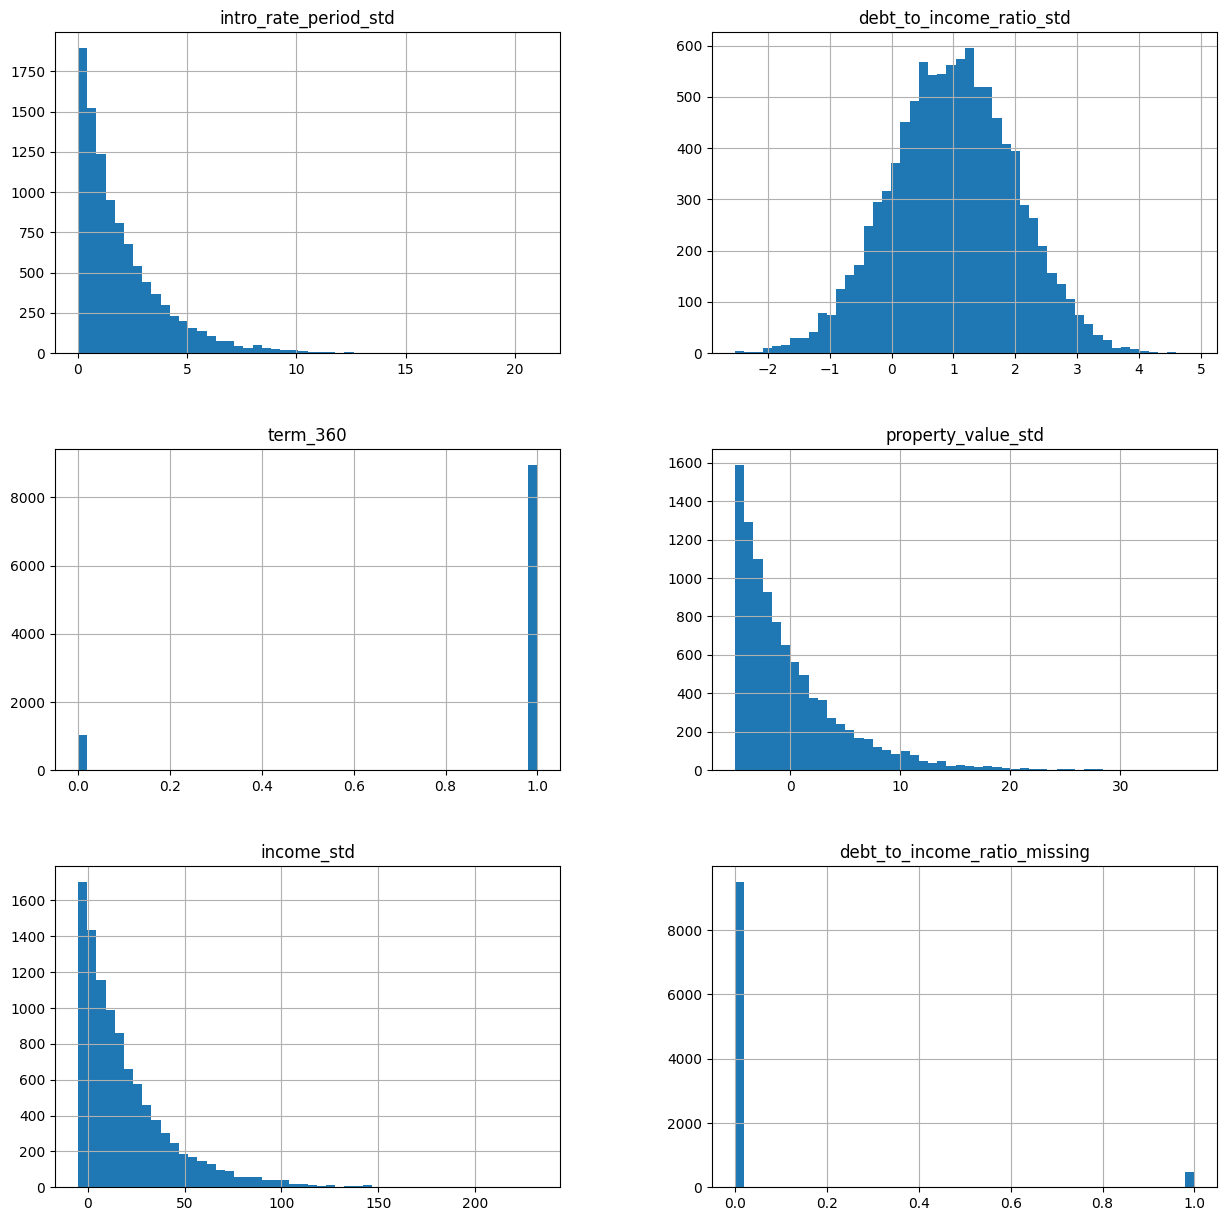

In [129]:
_ = random_frame[rem_x_names].hist(bins=50, figsize=(15, 15))

#### First call to blackbox model for predictions on random data

In [130]:
blackbox_phat = pd.DataFrame(rem_ebm.predict_proba(random_frame[rem_x_names])[:, 1], columns=['phat'])
blackbox_phat = pd.concat([random_frame.reset_index(drop=True), blackbox_phat], axis=1)
blackbox_phat.head()

,intro_rate_period_std,debt_to_income_ratio_std,term_360,property_value_std,income_std,debt_to_income_ratio_missing,phat
0,5.307581,0.270249,1,1.542979,-1.388380,0,0.000944
1,0.760693,1.215850,1,1.273303,26.605295,0,0.019914
2,0.406483,1.204969,1,-3.948261,34.300354,0,0.032761
3,0.457720,-0.216478,1,0.103183,26.431098,0,0.009856
4,1.677387,1.499916,1,0.233522,-2.397683,0,0.156322


#### Extract a stolen decision tree model

In [131]:
def get_cv_dt(x_names, y_name, train, model_id, seed_, title, valid=None):

    """ Utility function to train decision trees.
    Args:
        x_names: Names of input variables as a list.
        y_name: Name of target variable.
        train: Pandas DataFrame containing x_names and y_name on which to train
               decision tree.
        model_id: h2o model identifier.
        seed_: Random seed for improved reproducibility.
        title: Title for generated plot of tree.
        valid: Optional validation data.
    Returns:
        Model as h2o model object.
    """

    # initialize single tree model
    tree = H2ORandomForestEstimator(ntrees=1,  # use only one tree
                                    sample_rate=1,  # use all rows in that tree
                                    mtries=-2,  # use all columns in that tree's split search
                                    max_depth=4,  # shallow trees are easier to understand
                                    seed=seed_,  # set random seed for reproducibility
                                    nfolds=3,  # cross-validation for stability and ...
                                    # only way to get metrics for 1 tree in h2o
                                    model_id=model_id)  # gives MOJO artifact a recognizable name

    # train single tree model
    if valid is not None:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train), validation_frame=h2o.H2OFrame(valid))
    else:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train))

    # persist MOJO (compiled Java representation of trained model)
    # from which to generate plot of tree
    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)

    return tree

In [132]:
import h2o

# Try reconnecting to the existing server
try:
    h2o.init()
except H2OConnectionError:
    # If reconnecting fails, shutdown and restart
    h2o.shutdown(prompt=False)
    h2o.init()

# Now import after initializing H2O
from h2o.estimators.random_forest import H2ORandomForestEstimator  # for decision tree in model extraction

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,22 hours 28 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,5 months and 8 days
H2O_cluster_name:,H2O_from_python_Zeyu_t0ef0o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.579 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [133]:
stolen_dt = get_cv_dt(list(schema_dict.keys()),
                      'phat',
                      blackbox_phat,
                      'stolen_dt',
                      SEED,
                      'Stolen Model')

# Convert H2O MOJO to Graphviz .gv file
!java -cp "C:\\Users\\Zeyu\\AppData\\Roaming\\Python\\Python310\\site-packages\\h2o\\backend\\bin\\h2o.jar" hex.genmodel.tools.PrintMojo --tree 0 -i "stolen_dt.zip" -o stolen_dt.gv --title "Stolen Model"

# Convert .gv file to .png using Graphviz
! "C:\\Program Files\\Graphviz\\bin\\dot.exe" -Tpng stolen_dt.gv -o stolen_dt.png


# convert h2o MOJO (stolen_dt.zip) into GraphViz file (stolen_dt.png)
# !java -cp "/usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar" hex.genmodel.tools.PrintMojo --tree 0 -i "stolen_dt.zip" -o stolen_dt.gv --title "Stolen Model"
# three new files should appear:
# - stolen_dt.zip
# - stolen_dt.gv
# - stolen_dt.png
%ls

Generated MOJO path:
 C:\Users\Zeyu\Downloads\stolen_dt.zip
 Volume in drive C is Windows
 Volume Serial Number is EE4C-18E7

 Directory of C:\Users\Zeyu\Downloads

04/10/2025  06:38 PM    <DIR>          .
03/24/2025  07:50 AM    <DIR>          ..
04/08/2025  09:55 PM    <DIR>          .ipynb_checkpoints
03/28/2025  05:33 PM         2,830,972 01_Explainable_AI_Models (1).ipynb
03/28/2025  05:38 PM         2,830,972 01_Explainable_AI_Models (2).ipynb
03/24/2025  04:45 PM         2,797,645 01_Explainable_AI_Models.ipynb
03/24/2025  03:44 PM           158,046 assignment_1.pdf
04/09/2025  05:42 PM           110,568 assignment_4.pdf
03/24/2025  04:51 PM    <DIR>          backdoor_testing
04/07/2025  01:47 PM           231,833 CEAC Visa Status Check.pdf
08/26/2023  07:08 PM           103,280 Email_Bulk_Sender_GMAIL.xlsm
03/22/2025  02:47 PM            34,839 eval.ipynb
02/09/2025  07:46 PM         2,001,525 Future+Caps+LTP+2024-25 (1).pdf
04/10/2025  06:38 PM         1,547,260 group3_assignm

#### View stolen model

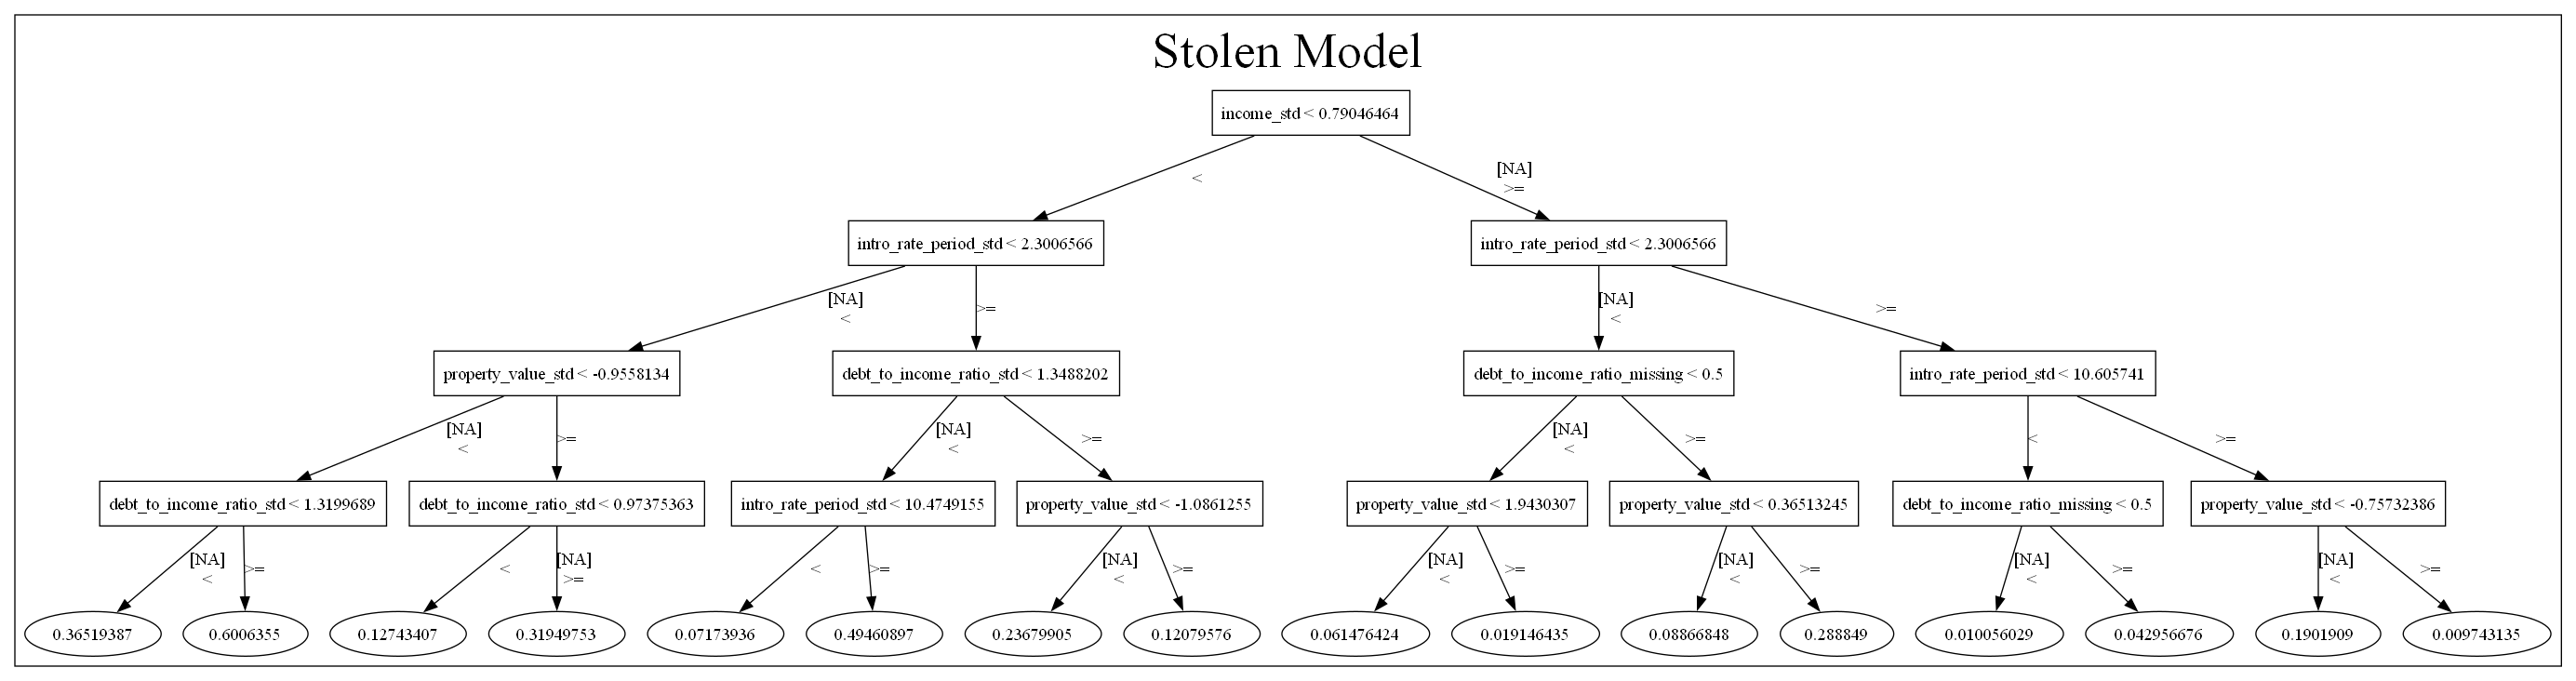

In [134]:
from IPython.display import Image
from IPython.display import display
display(Image(('stolen_dt.png')))

#### Variable importance for stolen model

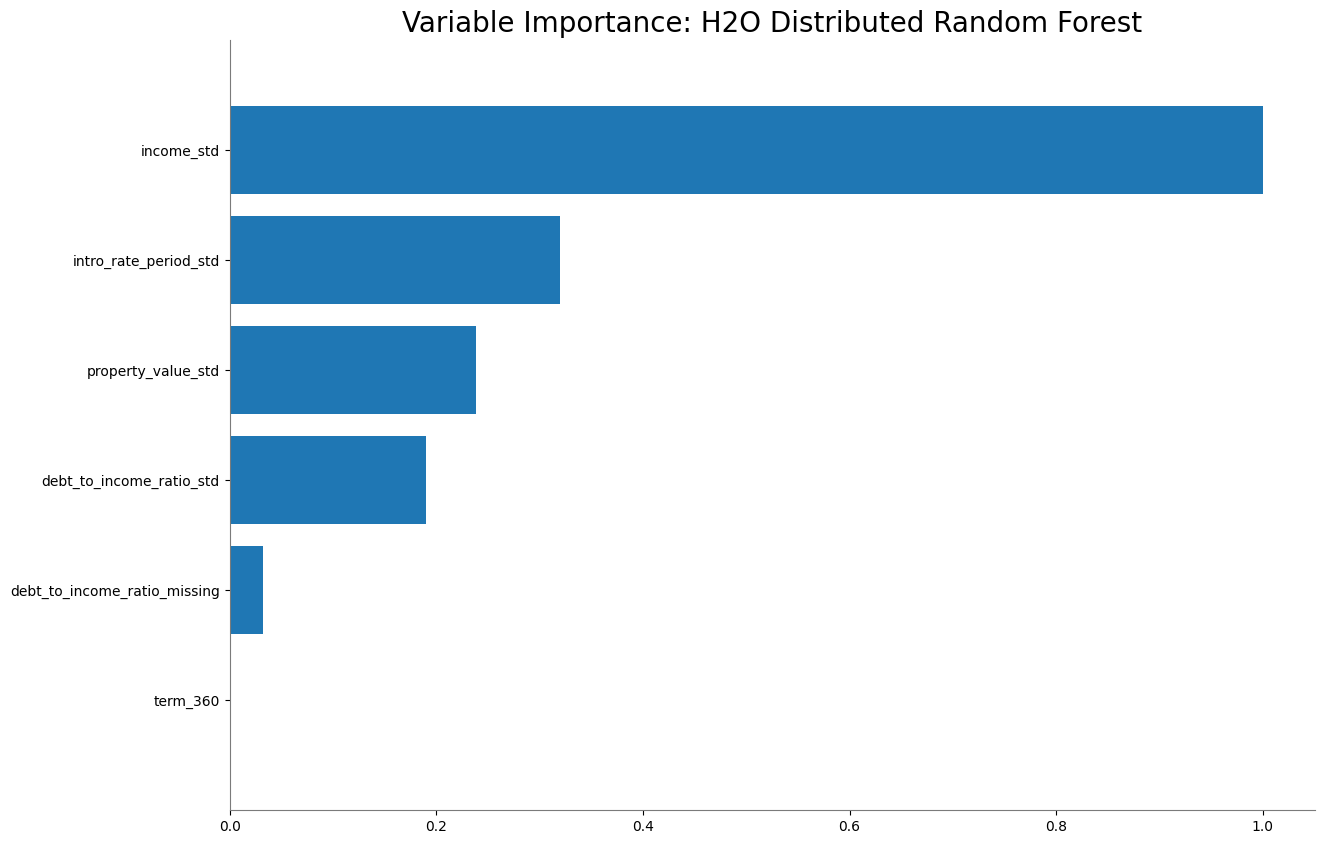

<Figure size 640x480 with 0 Axes>

In [135]:
stolen_dt.varimp_plot()

#### Assess accuracy of stolen model

In [136]:
stolen_dt.cross_validation_metrics_summary() # h2o makes cv evaluation metrics available

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
aic,nan,0.0,nan,nan,nan
loglikelihood,nan,0.0,nan,nan,nan
mae,0.0428172,0.0007130,0.0433655,0.0430747,0.0420112
mean_residual_deviance,0.0064570,0.0003971,0.0069155,0.0062337,0.0062218
mse,0.0064570,0.0003971,0.0069155,0.0062337,0.0062218
r2,0.7196552,0.0138752,0.7048804,0.7216761,0.7324092
residual_deviance,0.0064570,0.0003971,0.0069155,0.0062337,0.0062218
rmse,0.0803304,0.0024502,0.0831593,0.0789537,0.0788781
rmsle,0.0623563,0.0015826,0.0640959,0.0619713,0.0610018


## Assignment 4 PART 2: Use stolen model to find seed rows for adversary searches

#### Use stolen model to find seed rows for adversary searches

In [140]:
#low_adversary_seed = random_frame.loc[(random_frame['intro_rate_period_std'] >= 4.63) &
#                                      (random_frame['loan_amount_std'] < -1.25) &
#                                      (random_frame['property_value_std'] >= -0.9)].mean() # note this traces the stolen tree to the lowest prediction - does it trace your tree?
low_adversary_seed = random_frame.loc[
    (random_frame['intro_rate_period_std'] >= 2) & 
    (random_frame['debt_to_income_ratio_std'] >= 1.5) & 
    (random_frame['property_value_std'] >= -1.5) & 
    (random_frame['income_std'] < -1) & 
    (random_frame['term_360'] == 0) & 
    (random_frame['debt_to_income_ratio_missing'] == 1)].mean()

print('Low adversarial example search seed row:')
print(low_adversary_seed)

#high_adversary_seed = random_frame.loc[(random_frame['intro_rate_period_std'] < 2.26) &
#                                       (random_frame['income_std'] < 233) &
#                                       (random_frame['property_value_std'] < -0.8), :].mean() # note this traces the stolen tree to the highest prediction - does it trace your tree?

high_adversary_seed = random_frame.loc[
    (random_frame['intro_rate_period_std'] < 2.26) & 
    (random_frame['debt_to_income_ratio_std'] < 0.5) & 
    (random_frame['property_value_std'] < -1.0) &
    (random_frame['income_std'] > 2.0) & 
    (random_frame['term_360'] == 1) & 
    (random_frame['debt_to_income_ratio_missing'] == 0)].mean()

print('High adversarial example search seed row:')
print(high_adversary_seed)

Low adversarial example search seed row:
intro_rate_period_std           2.672756
debt_to_income_ratio_std        2.275553
term_360                        0.000000
property_value_std              1.450236
income_std                     -2.464544
debt_to_income_ratio_missing    1.000000
dtype: float64
High adversarial example search seed row:
intro_rate_period_std            0.915947
debt_to_income_ratio_std        -0.130764
term_360                         1.000000
property_value_std              -3.253141
income_std                      27.462110
debt_to_income_ratio_missing     0.000000
dtype: float64


#### Perturb seed row to find low scoring adversarial examples

In [145]:
# init results frames
# low_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys()))
low_adversary_frame = pd.DataFrame({
    'intro_rate_period_std': pd.Series(dtype=np.float64),
    'debt_to_income_ratio_std': pd.Series(dtype=np.float64),
    'term_360': pd.Series(dtype=np.int64),
    'property_value_std': pd.Series(dtype=np.float64),
    'income_std': pd.Series(dtype=np.float64),
    'debt_to_income_ratio_missing': pd.Series(dtype=np.int64)})

# quantiles over which to search
low_quantiles = [0.01, 0.05, 0.1, 0.25, 0.5]
high_quantiles = [0.99, 0.95, 0.9, 0.75, 0.5]

idx = 0

for a in list(random_frame['intro_rate_period_std'].quantile(high_quantiles)):
    for b in list(random_frame['income_std'].quantile(high_quantiles)):
        for c in list(random_frame['debt_to_income_ratio_std'].quantile(low_quantiles)):
            for d in list(random_frame['debt_to_income_ratio_missing'].quantile(low_quantiles)):
                for e in list(random_frame['property_value_std'].quantile(high_quantiles)):
                    for f in [0, 1]:  
                        
                        low_adversary_seed_frame = pd.DataFrame(
                            np.reshape(low_adversary_seed.values, (1, len(rem_x_names))),
                            columns=rem_x_names, index=[idx])
                        low_adversary_seed_frame['intro_rate_period_std'] = a
                        low_adversary_seed_frame['income_std'] = b
                        low_adversary_seed_frame['debt_to_income_ratio_std'] = c
                        low_adversary_seed_frame['debt_to_income_ratio_missing'] = d
                        low_adversary_seed_frame['property_value_std'] = e
                        low_adversary_seed_frame['term_360'] = f
                        low_adversary_frame = pd.concat([low_adversary_frame, low_adversary_seed_frame], axis=0)
                        idx += 1
                    
# view potential low scoring adversarial examples
low_adversary_frame.head()

,intro_rate_period_std,debt_to_income_ratio_std,term_360,property_value_std,income_std,debt_to_income_ratio_missing
0,9.105667,-1.36074,0,18.157891,108.350001,0.0
1,9.105667,-1.36074,1,18.157891,108.350001,0.0
2,9.105667,-1.36074,0,10.193480,108.350001,0.0
3,9.105667,-1.36074,1,10.193480,108.350001,0.0
4,9.105667,-1.36074,0,6.631031,108.350001,0.0


#### Perturb seed row to find high scoring adversarial examples

In [146]:
# init results frames
high_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys()))

for a in list(random_frame['intro_rate_period_std'].quantile(low_quantiles)):  
    for b in list(random_frame['income_std'].quantile(high_quantiles)):        
        for c in list(random_frame['debt_to_income_ratio_std'].quantile(low_quantiles)):  
            for d in list(random_frame['property_value_std'].quantile(low_quantiles)):    
                for e in [1]:  # term_360 = 1
                    for f in [0]:  # debt_to_income_ratio_missing = 0

                        high_adversary_seed_frame = pd.DataFrame(
                            np.reshape(high_adversary_seed.values, (1, len(rem_x_names))),
                            columns=rem_x_names, index=[idx])
                        high_adversary_seed_frame['intro_rate_period_std'] = a
                        high_adversary_seed_frame['income_std'] = b
                        high_adversary_seed_frame['debt_to_income_ratio_std'] = c
                        high_adversary_seed_frame['property_value_std'] = d
                        high_adversary_seed_frame['term_360'] = e
                        high_adversary_seed_frame['debt_to_income_ratio_missing'] = f
                        high_adversary_frame = pd.concat([high_adversary_frame, high_adversary_seed_frame], axis=0)
                        idx += 1

# view potential high scoring adversarial examples
high_adversary_frame.head()

C:\Users\Zeyu\AppData\Local\Temp\ipykernel_1456\891951958.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  high_adversary_frame = pd.concat([high_adversary_frame, high_adversary_seed_frame], axis=0)


,intro_rate_period_std,debt_to_income_ratio_std,term_360,property_value_std,income_std,debt_to_income_ratio_missing
6250,0.022736,-1.36074,1,-4.949140,108.350001,0
6251,0.022736,-1.36074,1,-4.744166,108.350001,0
6252,0.022736,-1.36074,1,-4.501055,108.350001,0
6253,0.022736,-1.36074,1,-3.597843,108.350001,0
6254,0.022736,-1.36074,1,-1.577774,108.350001,0


#### Second call to blackbox API to test adversarial examples

In [147]:
# combine potential adversaries so only one call to API is needed
adversaries = pd.concat([low_adversary_frame, high_adversary_frame], axis=0)

# score potential adversarial examples to understand their effect on generated predictions
blackbox_adversaries_phat = pd.DataFrame(rem_ebm.predict_proba(adversaries[rem_x_names])[:, 1], columns=['phat'])
blackbox_adversaries_phat = pd.concat([adversaries.reset_index(drop=True), blackbox_adversaries_phat], axis=1)
blackbox_adversaries_phat.sort_values(by='phat')

,intro_rate_period_std,debt_to_income_ratio_std,term_360,property_value_std,income_std,debt_to_income_ratio_missing,phat
640,9.105667,-0.303334,0,18.157891,53.211273,0.0,7.914004e-07
50,9.105667,-0.676000,0,18.157891,108.350001,0.0,7.914004e-07
350,9.105667,-0.303334,0,18.157891,71.084050,0.0,7.914004e-07
390,9.105667,-0.303334,0,18.157891,71.084050,0.0,7.914004e-07
570,9.105667,-0.676000,0,18.157891,53.211273,0.0,7.914004e-07
...,...,...,...,...,...,...,...
6372,0.022736,1.002282,1,-4.501055,12.448478,0,2.018218e-01
6373,0.022736,1.002282,1,-3.597843,12.448478,0,2.018218e-01
6374,0.022736,1.002282,1,-1.577774,12.448478,0,2.018218e-01
6370,0.022736,1.002282,1,-4.949140,12.448478,0,2.018218e-01


#### End timer

In [148]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 140289.82 s.


#### Shutdown H2O

In [126]:
# h2o.cluster().shutdown(prompt=True)